In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42767")
client

<Client: 'tcp://127.0.0.1:42767' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
import xrft
import s3fs
import gsw

import glob

import gcm_filters

import seaborn as sns

import os.path as op

from scipy.interpolate import griddata, interpn

from xeofs.models import EOF
from pydmd import DMD, BOPDMD, MrDMD
from pydmd.mrcosts import mrCOSTS
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_eigs, plot_summary

from matplotlib import ticker
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sdir = '/tank/spectre/tuchida/SWOT/'
ddir = '/tank/spectre/tuchida/DMD/'

In [5]:
grav = 9.807
ds = xr.open_dataset(op.join(sdir, '01-day-repeat/swot_calval_v0.3.nc')
                    )
ds

<xarray.Dataset>
Dimensions:                  (cycle_num: 105, pass_num: 28, num_lines: 9860,
                              num_pixels: 69)
Coordinates:
  * cycle_num                (cycle_num) int64 474 475 476 477 ... 576 577 578
    latitude                 (cycle_num, pass_num, num_lines, num_pixels) float64 ...
    longitude                (cycle_num, pass_num, num_lines, num_pixels) float64 ...
  * pass_num                 (pass_num) int64 1 2 3 4 5 6 ... 23 24 25 26 27 28
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    internal_tide_hret       (cycle_num, pass_num, num_lines, num_pixels) float64 ...
    ssha_karin_2_calibrated  (cycle_num, pass_num, num_lines, num_pixels) float64 ...
    ssha_karin_2_filtered    (cycle_num, pass_num, num_lines, num_pixels) float64 ...
    ssha_karin_2_unet_gomez  (cycle_num, pass_num, num_lines, num_pixels) float32 ...
    time                     (cycle_num, pass_num, num_lines) datetime64[ns] ...
Attributes:
    Extracted by:    B. Yadidya
    Extracted on:    Jan 30, 2024
    Directory:       /work/HELPDESK_SWOTLR/commun/data/swot/L3_LR_SSH/v0.3_ca...
    Extracted from:  Jupyterhub CNES HPC

In [ ]:
for cc in ds.cycle_num:

    gs = 0
    for pp in ds.pass_num:
        
        dsgs = ds.sel(cycle_num=cc, pass_num=pp
                     ).where(ds.sel(cycle_num=cc, pass_num=pp
                                   ).latitude>30-1, drop=True)
        dsgs = dsgs.where(dsgs.latitude<40+1, drop=True)
        dsgs = dsgs.where(dsgs.longitude>360-78-1, drop=True)
        dsgs = dsgs.where(dsgs.longitude<360-68+1, drop=True)

        if dsgs.ssha_karin_2_filtered.sum() != 0.:
            if gs == 0:
                dsGS = dsgs
            else:
                dsGS = xr.concat([dsGS, dsgs
                                 ], 'pass_num')
            gs += 1

    dsGS.to_zarr(op.join(sdir,
                         '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                         % cc.values), mode='w')
    dsGS.close()
    print(cc.values)

(2, 695, 65) 695 65


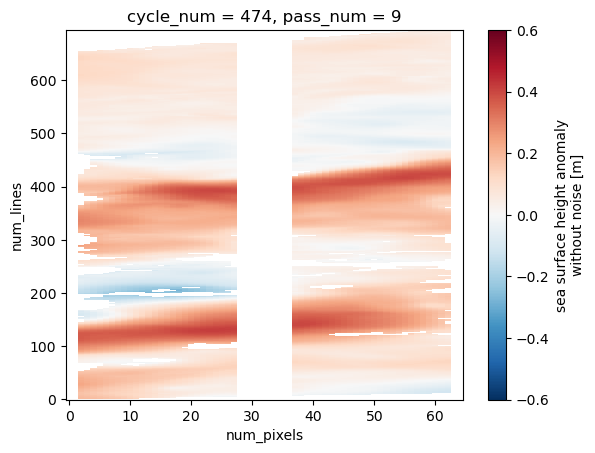

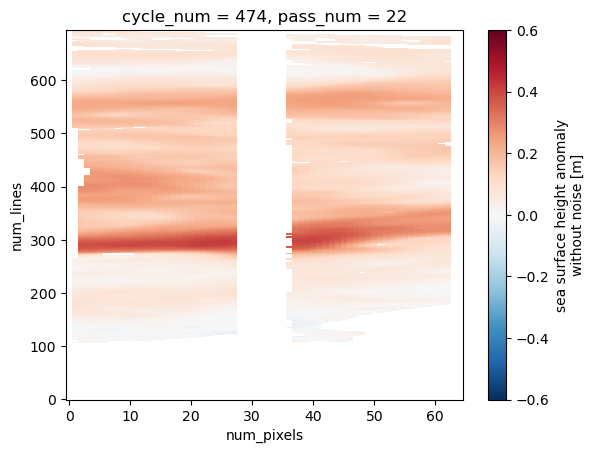

(2, 695, 65) 695 65


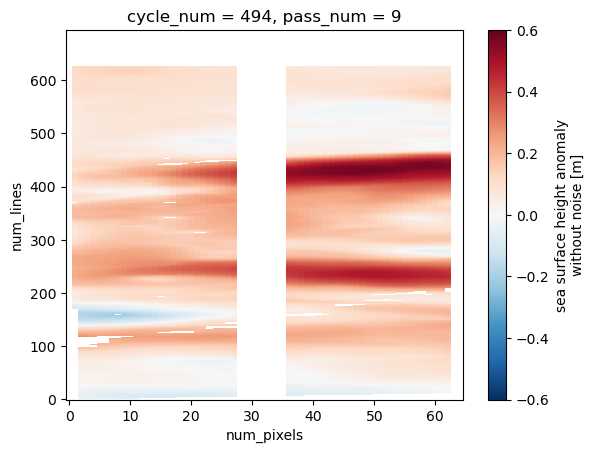

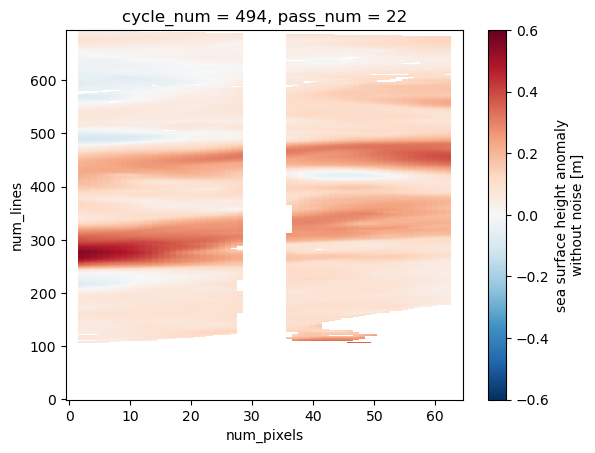

(2, 695, 65) 695 65


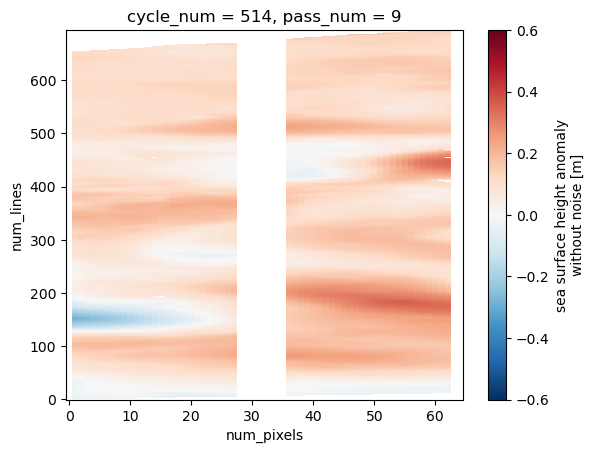

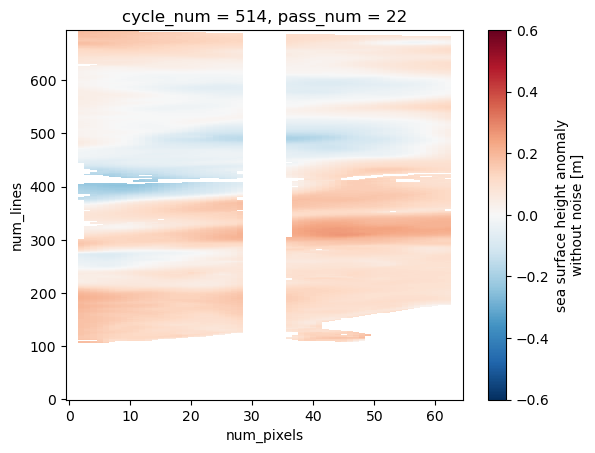

(2, 695, 65) 695 65


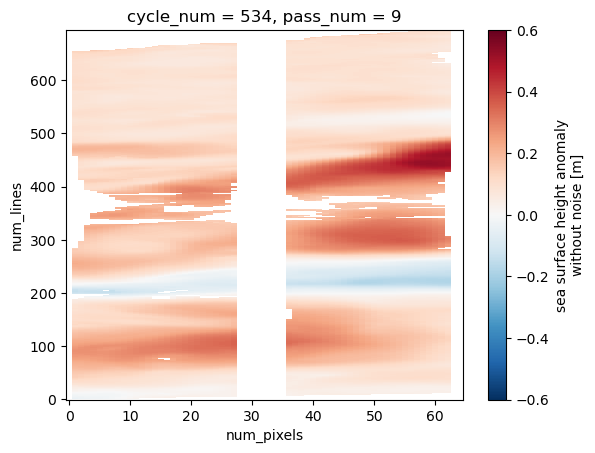

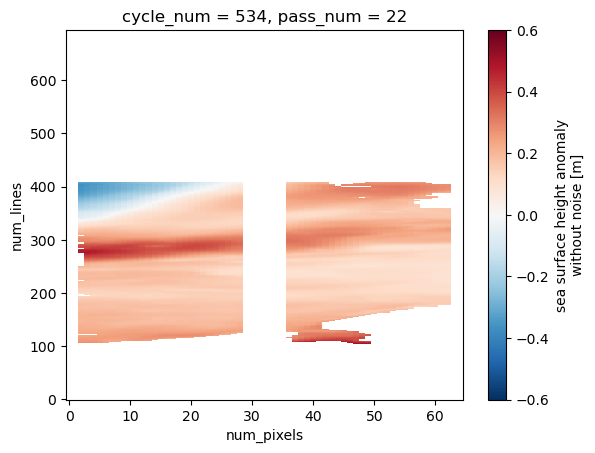

(2, 695, 65) 695 65


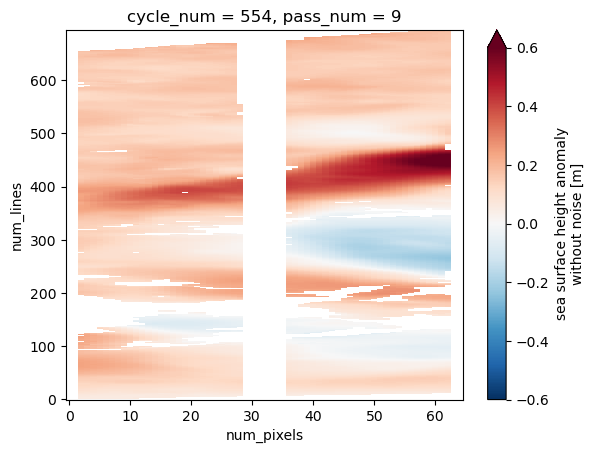

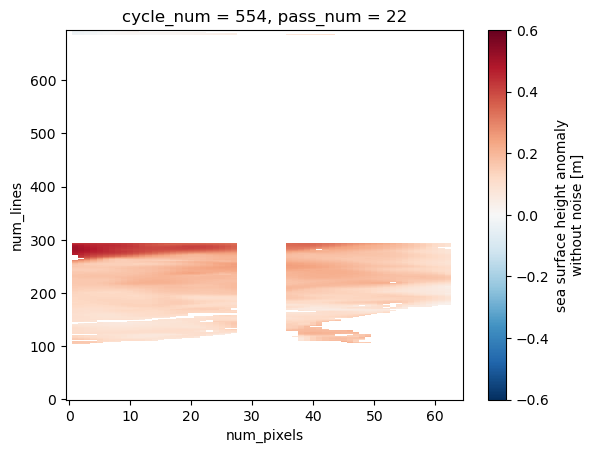

(695, 65) 695 65


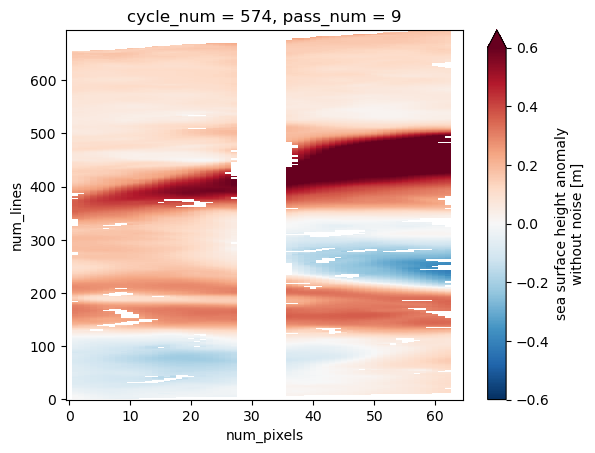

In [325]:
for cc in ds.cycle_num[::20]:
    dsGS = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                % cc.values)
                       ).isel(num_pixels=slice(2,-2),
                              # num_lines=slice(20,-40)
                             )
    print(dsGS.ssha_karin_2_filtered.shape, 
          len(dsGS.num_lines),
          len(dsGS.num_pixels))
    if dsGS.ssha_karin_2_filtered.ndim > 2:
        for pp in dsGS.pass_num:
            fig, ax = plt.subplots()
            dsGS.ssha_karin_2_filtered.sel(pass_num=pp).plot(
                          ax=ax,
                          vmax=.6, vmin=-.6, cmap='RdBu_r',
                          rasterized=True)
                # ax.set_ylim([30,40])
                # ax.set_xlim([360-78,360-68])
            plt.show()
    else:
        fig, ax = plt.subplots()
        dsGS.ssha_karin_2_filtered.plot(
                          ax=ax,
                          vmax=.6, vmin=-.6, cmap='RdBu_r',
                          rasterized=True)
                # ax.set_ylim([30,40])
                # ax.set_xlim([360-78,360-68])
        plt.show()

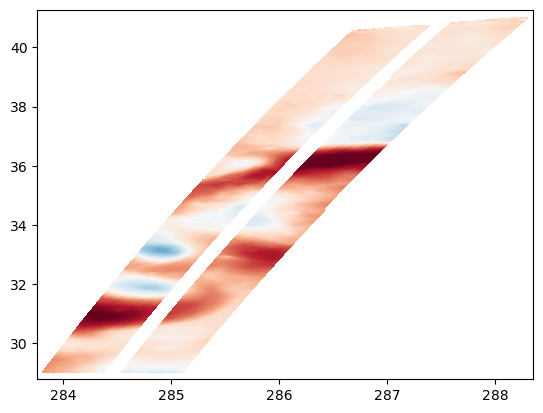

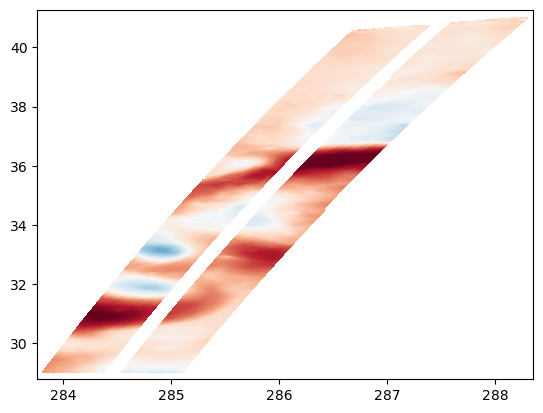

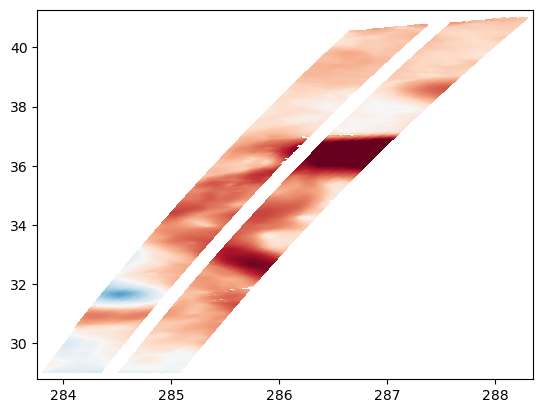

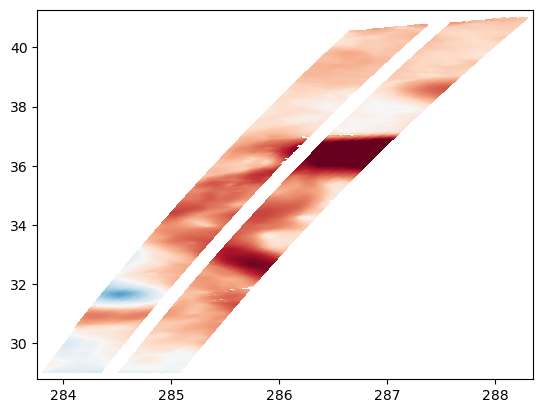

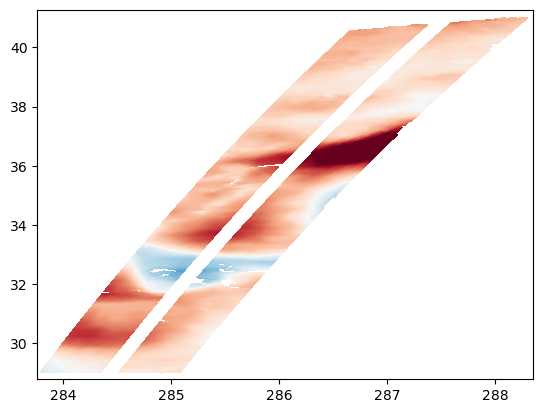

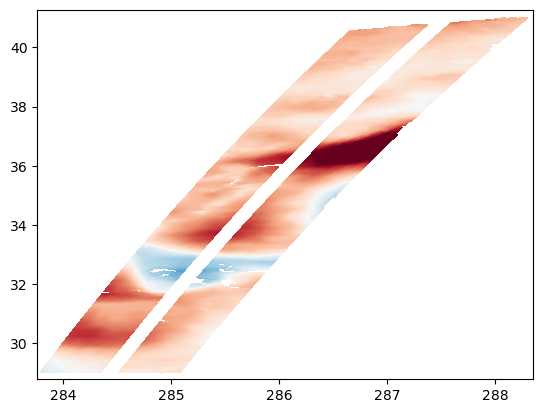

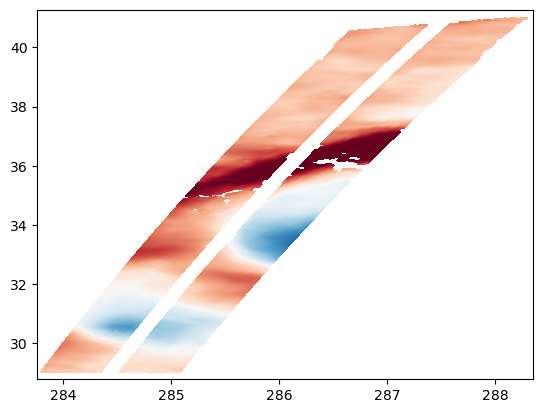

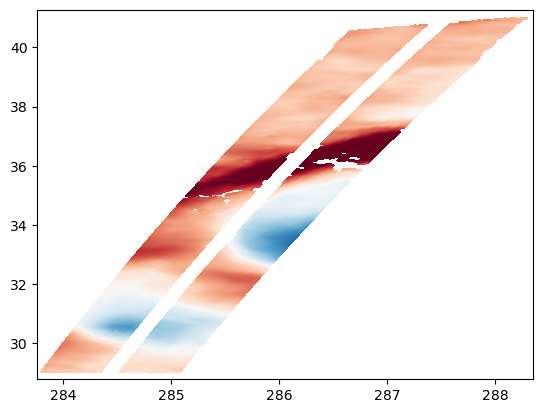

In [25]:
for cc in ds.cycle_num:
    dsGS = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                % cc.values)
                       ).isel(num_pixels=slice(2,-2),
                              # num_lines=slice(20,-40)
                             )
    # print(dsGS.ssha_karin_2_filtered.ndim)
    if cc % 20 == 0:
        if dsGS.ssha_karin_2_filtered.ndim > 2:
            for pp in dsGS.pass_num:
                if dsGS.ssha_karin_2_filtered.sel(pass_num=9).sum(skipna=True) != 0.:
                    fig, ax = plt.subplots()
                    ax.pcolor(dsGS.longitude.sel(pass_num=9), 
                              dsGS.latitude.sel(pass_num=9),
                              dsGS.ssha_karin_2_filtered.sel(pass_num=9),
                              vmax=.4, vmin=-.4, cmap='RdBu_r',
                              rasterized=True)
                    # ax.set_ylim([30,40])
                    # ax.set_xlim([360-78,360-68])
                    plt.show()
        else:
            if dsGS.pass_num == 9:
                fig, ax = plt.subplots()
                ax.pcolor(dsGS.longitude, 
                          dsGS.latitude,
                          dsGS.ssha_karin_2_filtered,
                          vmax=.4, vmin=-.4, cmap='RdBu_r',
                          rasterized=True)
                        # ax.set_ylim([30,40])
                        # ax.set_xlim([360-78,360-68])
                plt.show()

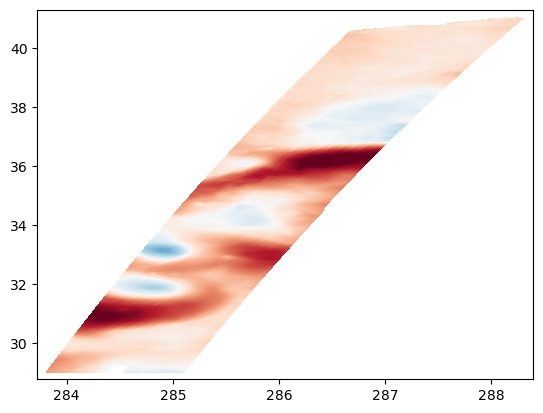

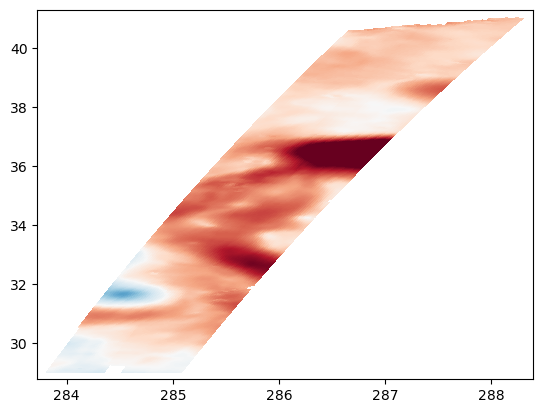

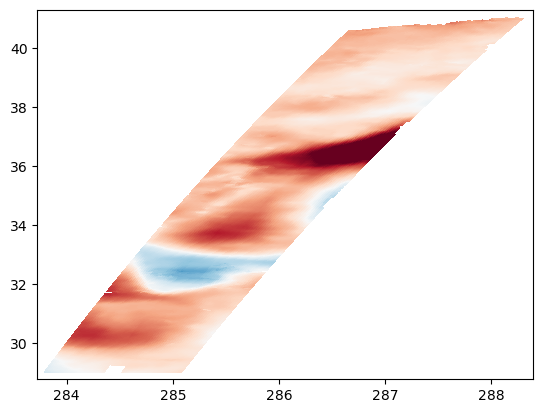

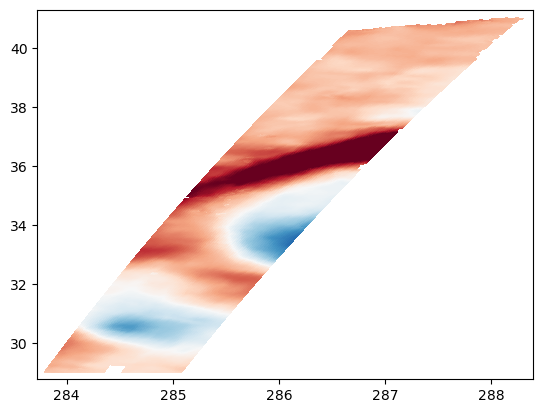

In [41]:
meth = 'linear'
npi = 6
nli = 20

for cc in ds.cycle_num:
    dsGS = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                % cc.values)
                       )
    dsGS_sub = dsGS.isel(num_pixels=slice(npi,-npi),
                         num_lines=slice(nli,-nli)
                        )

    # yy, xx = np.mgrid[
    #     dsGS.num_lines.min().values: dsGS.num_lines.max().values+1: 1,
    #     dsGS.num_pixels.min().values:dsGS.num_pixels.max().values+1:1
    # ]
    
    ssha = dsGS.ssha_karin_2_filtered.chunk({"num_lines":100,
                                             "num_pixels":-1}
                                           ).reset_coords(drop=True)
    # ssha = dsGS.ssha_karin_2_filtered.interpolate_na(
    #     num_lines=dsGS.num_lines.data,
    #     num_pixels=dsGS.num_pixels.data,
    #     kwargs={"fill_value": "extrapolate"})
    if ssha.ndim > 2:
        ip = 0
        for pp in ssha.pass_num:
            array = dsGS_sub.ssha_karin_2_filtered.sel(pass_num=pp).to_masked_array()
            #get only the valid values
            x1 = dsGS_sub.longitude.sel(pass_num=pp).values[~array.mask]
            y1 = dsGS_sub.latitude.sel(pass_num=pp).values[~array.mask]
            newarr = array[~array.mask]
            ssha[dict(pass_num=ip,
                      num_pixels=slice(npi,-npi),
                      num_lines=slice(nli,-nli))
                ] = griddata((y1,x1),
                             newarr.flatten(), 
                             (dsGS_sub.latitude.sel(pass_num=pp).values,
                             dsGS_sub.longitude.sel(pass_num=pp).values), 
                             method=meth, 
                           # fill_value=0.
                            )
            ip += 1
        # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(num_pixels=slice(None,np),
        #                                                          num_lines=slice(nl,-nl)
        #                                                         ).reset_coords(drop=True),
        #                              ssha],'num_pixels'), 
        #                   dsGS.ssha_karin_2_filtered.sel(pass_num=pp
        #                                                 ).isel(num_pixels=slice(-np,None),
        #                                                        num_lines=slice(nl,-nl)
        #                                                       ).reset_coords(drop=True)
        #                  ],'num_pixels')
        # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(
        #                                                     num_lines=slice(None,nl)
        #                                                         ).reset_coords(drop=True),
        #                              ssha],'num_lines'), 
        #                   dsGS.ssha_karin_2_filtered.sel(pass_num=pp
        #                                                 ).isel(num_lines=slice(-nl,None)
        #                                                       ).reset_coords(drop=True)
        #                  ],'num_lines'
        #                 ).chunk({"num_lines":100,
        #                          "num_pixels":-1}
        #                        )
            # ssha[dict(pass_num=pp)
            # ] = interpn((dsGS.num_lines.data, dsGS.num_pixels.data),
            #             dsGS.ssha_karin_2_filtered.sel(pass_num=pp).values,
            #             (dsGS.num_lines.data, dsGS.num_pixels.data),
            #             fill_value=None
            #            )
        if cc % 20 == 0:
            fig, ax = plt.subplots()
            ax.pcolor(dsGS.longitude.sel(pass_num=9), 
                      dsGS.latitude.sel(pass_num=9),
                      ssha.sel(pass_num=9),
                      vmax=.4, vmin=-.4, cmap='RdBu_r',
                      rasterized=True)
                    # ax.set_ylim([30,40])
                    # ax.set_xlim([360-78,360-68])
            plt.show()
        dsave = xr.DataArray(ssha.data, dims=['pass_num','num_lines','num_pixels'],
                             coords={'pass_num':dsGS.pass_num.values}
                            ).to_dataset(name='ssha')
        # dsave.coords['latitude'] = dsGS.latitude.chunk({"num_lines":100,"num_pixels":-1})
        # dsave.coords['longitude'] = dsGS.longitude.chunk({"num_lines":100,"num_pixels":-1})
        fname = op.join(sdir,
                        '01-day-repeat/GulfStream/Cyc-num%03d_' % cc.values
                       )+meth+'filtered.zarr' 
        # print(fname)
        dsave.to_zarr(fname, mode='w'
                     )
        dsave.close()
    else:
        if dsGS_sub.pass_num == 9:
            array = dsGS_sub.ssha_karin_2_filtered.to_masked_array()
            #get only the valid values
            x1 = dsGS_sub.longitude.values[~array.mask]
            y1 = dsGS_sub.latitude.values[~array.mask]
            newarr = array[~array.mask]
            ssha[dict(num_pixels=slice(npi,-npi),
                      num_lines=slice(nli,-nli))
                ] = griddata((y1,x1),
                             newarr.flatten(), 
                             (dsGS_sub.latitude.values,
                             dsGS_sub.longitude.values), 
                             method=meth,
                               # fill_value=0.
                            )
            # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(
            #                                                      num_pixels=slice(None,np),
            #                                                      num_lines=slice(nl,-nl)
            #                                                     ).reset_coords(drop=True),
            #                              ssha],'num_pixels'), 
            #                   dsGS.ssha_karin_2_filtered.isel(num_pixels=slice(-np,None),
            #                                                   num_lines=slice(nl,-nl)
            #                                                  ).reset_coords(drop=True)
            #          ],'num_pixels')
            # ssha = xr.concat([xr.concat([dsGS.ssha_karin_2_filtered.isel(
            #                                                      num_lines=slice(None,nl)
            #                                                     ).reset_coords(drop=True),
            #                              ssha],'num_lines'), 
            #                   dsGS.ssha_karin_2_filtered.isel(num_lines=slice(-nl,None)
            #                                                  ).reset_coords(drop=True)
            #          ],'num_lines'
            #                 ).chunk({"num_lines":100,
            #                          "num_pixels":-1}
            #                        )
            # ssha[:] = interpn((dsGS.num_lines.data, dsGS.num_pixels.data),
            #                   dsGS.ssha_karin_2_filtered.values,
            #                   (dsGS.num_lines.data, dsGS.num_pixels.data),
            #                   fill_value=None
            #                  )
            if cc % 20 == 0:
                fig, ax = plt.subplots()
                ax.pcolor(dsGS.longitude, 
                          dsGS.latitude,
                          ssha,
                          vmax=.4, vmin=-.4, cmap='RdBu_r',
                          rasterized=True)
                        # ax.set_ylim([30,40])
                        # ax.set_xlim([360-78,360-68])
                plt.show()

            dsave = xr.DataArray(ssha.data, dims=['num_lines','num_pixels']
                                ).to_dataset(name='ssha')
            # dsave.coords['latitude'] = dsGS.latitude.chunk({"num_lines":100,"num_pixels":-1})
            # dsave.coords['longitude'] = dsGS.longitude.chunk({"num_lines":100,"num_pixels":-1})
            fname = op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d_' % cc.values
                           )+meth+'filtered.zarr' 
            # print(fname)
            dsave.to_zarr(fname, mode='w'
                         )
            dsave.close()
    dsGS.close()

In [18]:
npix = 4
nlin = 40

In [54]:
ic = 0

for cc in ds.cycle_num:
    dsGS = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                % cc.values)
                       ).isel(num_pixels=slice(npix,-npix),
                              num_lines=slice(nlin,-nlin)
                             )

    if dsGS.ssha_karin_2_filtered.ndim > 2:

        ssha = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                             % cc.values)
                           ).ssha.sel(pass_num=9).isel(num_pixels=slice(npix,-npix),
                                                       num_lines=slice(nlin,-nlin)
                                                      )
        ssha = xr.DataArray(ssha.data[np.newaxis], 
                            dims=['cycle_num','num_lines','num_pixels'],
                            coords={'cycle_num':np.array([cc.values]),
                                    'num_lines':dsGS.num_lines.data,
                                    'num_pixels':dsGS.num_pixels.data}
                           )
        # ssha.coords['time'] = dsGS.time.sel(pass_num=9)
        # ssha.coords['lat'] = dsGS.latitude.sel(pass_num=9)
        # ssha.coords['long'] = dsGS.longitude.sel(pass_num=9)
    else:
        if dsGS.pass_num.values == 9:
            
            ssha = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                                % cc.values)
                               ).ssha.isel(num_pixels=slice(npix,-npix),
                                           num_lines=slice(nlin,-nlin)
                                          )
            ssha = xr.DataArray(ssha.data[np.newaxis], 
                                dims=['cycle_num','num_lines','num_pixels'],
                                coords={'cycle_num':np.array([cc.values]),
                                        'num_lines':dsGS.num_lines.data,
                                        'num_pixels':dsGS.num_pixels.data}
                               )
            # ssha.coords['time'] = dsGS.time
    # ssha.plot()
    # plt.show()
    if dsGS.pass_num.sum() == 9 or dsGS.pass_num.sum() == 31:
        array = ssha.to_masked_array()
        mask = ~array.mask
        ratio = mask.sum() / np.prod(mask.shape)
        if ic == 0:
            R = xr.DataArray(np.array([ratio]), 
                             dims='cycle_num', 
                             coords={'cycle_num':np.array([cc.values])}
                            )
        else:
            R = xr.concat([R, xr.DataArray(np.array([ratio]), 
                           dims='cycle_num', 
                           coords={'cycle_num':np.array([cc.values])}
                         )], 'cycle_num')
        if ratio > .7:
            if ic == 0:
                H = ssha
            else:
                try:
                    H = xr.concat([H, ssha], 'cycle_num')
                except:
                    pass
            ic += 1
        del ssha, mask, array
    dsGS.close()

H

<xarray.DataArray 'getitem-ef6d2ab9eff40b41bf6eea0a7e37685e' (cycle_num: 100,
                                                              num_lines: 615,
                                                              num_pixels: 61)>
dask.array<concatenate, shape=(100, 615, 61), dtype=float64, chunksize=(1, 100, 61), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 474 475 476 477 478 ... 574 575 576 577 578
  * num_lines   (num_lines) int64 0 1 2 3 4 5 6 ... 608 609 610 611 612 613 614
  * num_pixels  (num_pixels) int64 0 1 2 3 4 5 6 7 8 ... 53 54 55 56 57 58 59 60

In [8]:
H_interp = H.chunk({'num_lines':-1}
                  ).interpolate_na(dim='num_pixels', method='slinear', 
                                   fill_value="extrapolate"
                                  ).interpolate_na(dim='num_lines', method='slinear', 
                                                   fill_value="extrapolate"
                                                  ).interp(cycle_num=ds.cycle_num,
                                                           method='slinear',
                                                           kwargs={'fill_value':
                                                                   'extrapolate'}
                                                          )
# H_interp = H.chunk({'num_lines':-1}
#                   ).interp(cycle_num=ds.cycle_num,
#                            method='slinear',
#                            kwargs={'fill_value':'extrapolate'}
#                           )
# h_interp = H_interp - H_interp.mean(['num_lines','num_pixels'])
H_interp

<xarray.DataArray 'getitem-ef6d2ab9eff40b41bf6eea0a7e37685e' (cycle_num: 105,
                                                              num_lines: 615,
                                                              num_pixels: 61)>
dask.array<transpose, shape=(105, 615, 61), dtype=float64, chunksize=(105, 615, 61), chunktype=numpy.ndarray>
Coordinates:
  * num_lines   (num_lines) int64 0 1 2 3 4 5 6 ... 608 609 610 611 612 613 614
  * num_pixels  (num_pixels) int64 0 1 2 3 4 5 6 7 8 ... 53 54 55 56 57 58 59 60
  * cycle_num   (cycle_num) int64 474 475 476 477 478 ... 574 575 576 577 578

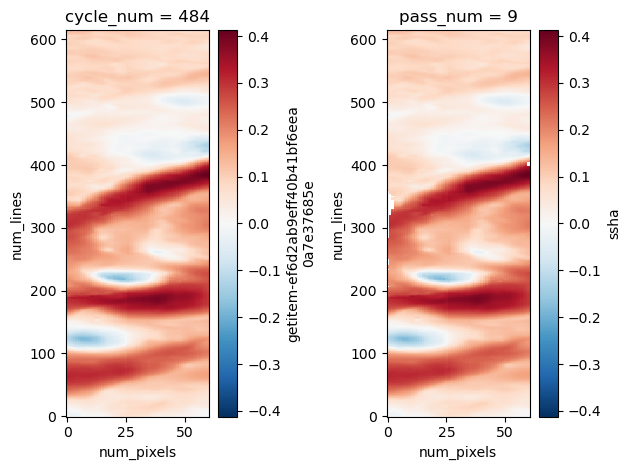

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)

H_interp.sel(cycle_num=ds.cycle_num[10]).plot(ax=ax1, rasterized=True)
xr.open_zarr(op.join(sdir,'01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                     % ds.cycle_num[10].values)
            ).ssha.sel(pass_num=9
                      ).isel(num_pixels=slice(npix,-npix),
                             num_lines=slice(nlin,-nlin)
                            ).plot(ax=ax2, rasterized=True)

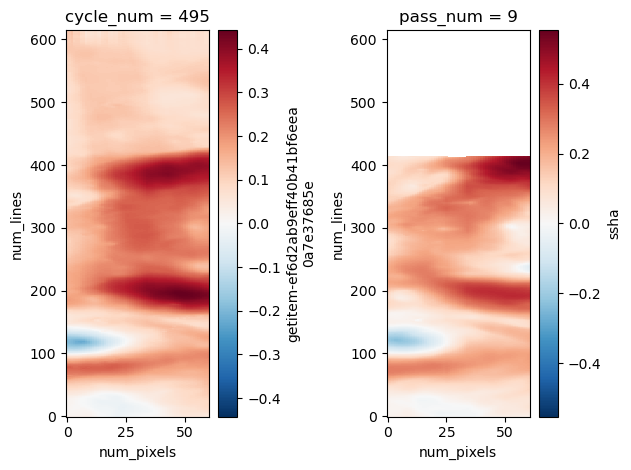

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)

H_interp.sel(cycle_num=495).plot(ax=ax1, rasterized=True)
xr.open_zarr(op.join(sdir,'01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                     % 495)
            ).ssha.sel(pass_num=9
                      ).isel(num_pixels=slice(npix,-npix),
                             num_lines=slice(nlin,-nlin)
                            ).plot(ax=ax2, rasterized=True)

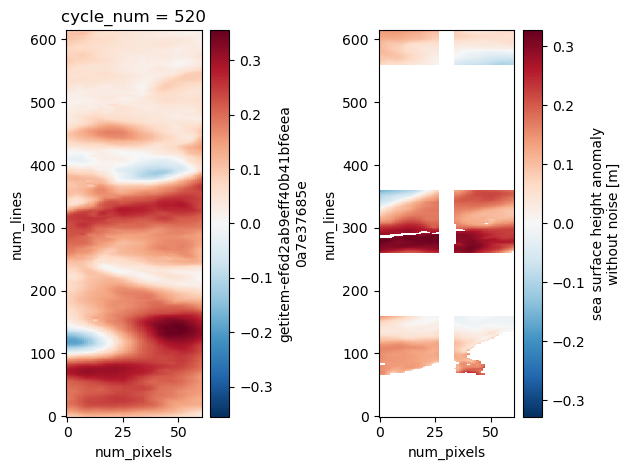

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)
H_interp.sel(cycle_num=520).plot(ax=ax1, rasterized=True)
xr.open_zarr(op.join(sdir,'01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                     % 520)     # probably pass_num=22
            ).ssha.isel(num_pixels=slice(npix,-npix),
                        num_lines=slice(nlin,-nlin)
                       ).plot(ax=ax2, rasterized=True)

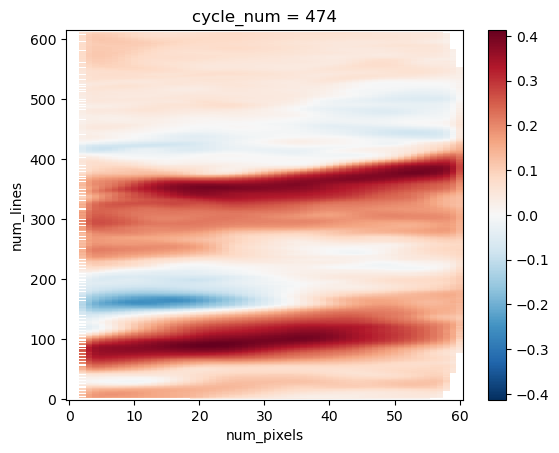

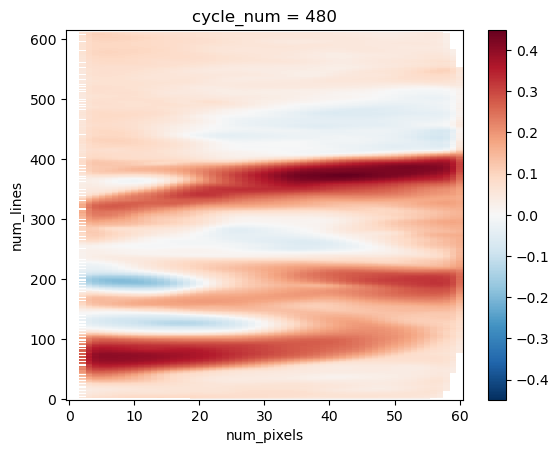

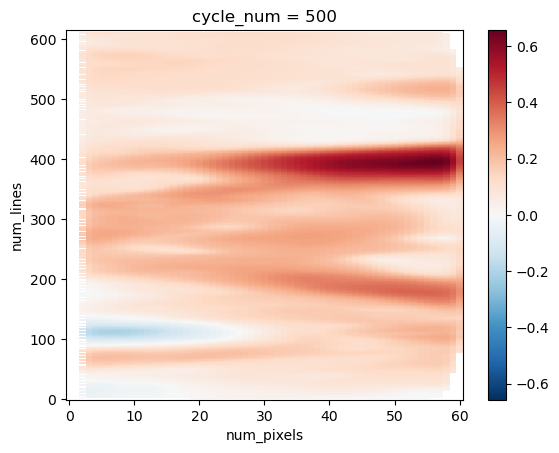

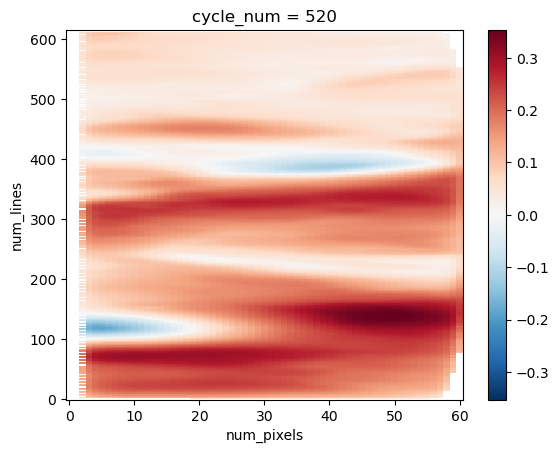

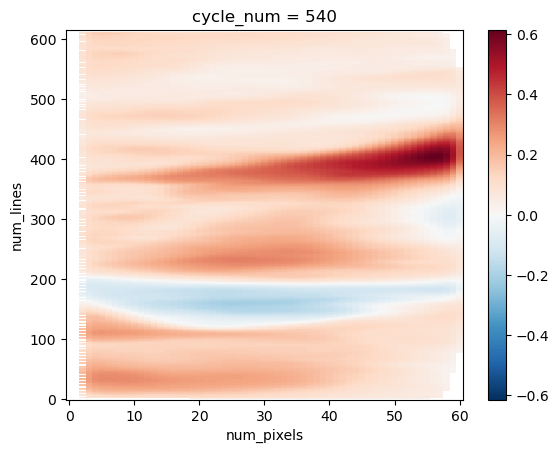

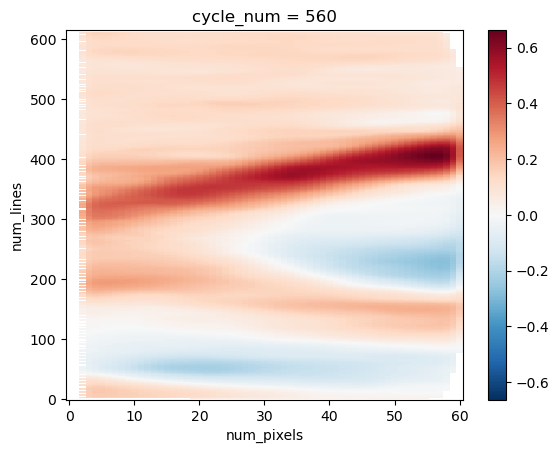

In [15]:
for cc in H_interp.cycle_num:

    try:
        dsGS = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                            % cc.values)
                   ).isel(num_pixels=slice(npix,-npix),
                          num_lines=slice(nlin,-nlin)
                         ).sel(pass_num=9)
    except:
        dsgs = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                            % cc.values)
                   ).isel(num_pixels=slice(npix,-npix),
                          num_lines=slice(nlin,-nlin)
                         )
        if dsgs.pass_num.values == 9:
            dsGS = dsgs.copy()
            dsgs.close()

    yy, xx = np.mgrid[dsGS.latitude.min(skipna=True).values:dsGS.latitude.max(skipna=True).values:np.abs(dsGS.latitude.diff('num_lines').min(skipna=True).values),
                  dsGS.longitude.min(skipna=True).values:dsGS.longitude.max(skipna=True).values:np.abs(dsGS.longitude.diff('num_pixels').min(skipna=True).values)
                 ]
    lon = griddata((dsGS.latitude.values.flatten(),
                    dsGS.longitude.values.flatten()), 
                    dsGS.longitude.values.flatten(), 
                   (yy, xx), method='linear'
                  )
    lat = griddata((dsGS.latitude.values.flatten(),
                    dsGS.longitude.values.flatten()), 
                    dsGS.latitude.values.flatten(), 
                   (yy, xx), method='linear'
                  )
    meth = 'linear'
    ssh = griddata((dsGS.latitude.values.flatten(),
                    dsGS.longitude.values.flatten()), 
                    H_interp.sel(cycle_num=cc).values.flatten(), 
                   (yy, xx), method=meth
                  )

    dss = xr.DataArray(ssh, dims=['YC','XC'], 
                       coords={'YC':np.mean(yy, axis=1),
                               'XC':np.mean(xx, axis=0)}
                      ).to_dataset(name='ssh')

    dx = gsw.distance(lon, lat, p=0, axis=-1)
    dy = gsw.distance(lon, lat, p=0, axis=0)
    dss['dxC'] = xr.DataArray(dx, dims=['YC','XF'],
                              coords={'YC':np.mean(yy, axis=1),
                                      'XF':np.mean(.5*(xx[:,1:] + xx[:,:-1]), 
                                                   axis=0)}
                     )
    dss['dyC'] = xr.DataArray(dy, dims=['YF','XC'],
                              coords={'YF':np.mean(.5*(yy[1:] + yy[:-1]), 
                                                   axis=1),
                                      'XC':np.mean(xx, axis=0)}
                     )

    coords={
            'X':{'center':'XC', 'inner':'XF'}, 
            'Y':{'center':'YC', 'inner':'YF'},
           }
    grid = Grid(dss, periodic=[], coords=coords)

    dxG = grid.interp(grid.interp(dss.dxC,'X',boundary='extend'),
                      'Y',boundary='extend',to='inner')
    dyG = grid.interp(grid.interp(dss.dyC,'X',boundary='extend',to='inner'),
                      'Y',boundary='extend')
    dxF = grid.interp(dss.dxC,'X',boundary='extend')
    dyF = grid.interp(dss.dyC,'Y',boundary='extend')

    mask = ~dss.ssh.to_masked_array().mask

    wet_mask = xr.DataArray(np.zeros((len(dss.YC),len(dss.XC))),
                            dims=['YC','XC'],
                            coords={'YC':dss.YC,'XC':dss.XC}
                   )
    wet_mask[1:-1,1:-1] = mask[1:-1,1:-1].astype(np.float64)
    # if cc == H_interp.cycle_num[0]:
    #     wet_mask.plot(rasterized=True)
    #     plt.show()

    area = (dxF * dyF)

    dxw = xr.DataArray(np.pad(dss.dxC.data, ((0,0),(0,1)), 'edge'),
                       dims=area.dims, coords=area.coords
                      ) # x-spacing centered at western cell edge
        
    dyw = xr.DataArray(np.pad(dyG.data, ((0,0),(0,1)), 'edge'),
                       dims=area.dims, coords=area.coords
                      ) # y-spacing centered at western cell edge
        
    dxs = xr.DataArray(np.pad(dxG.data, ((0,1),(0,0)), 'edge'),
                       dims=area.dims, coords=area.coords
                      ) # x-spacing centered at southern cell edge
        
    dys = xr.DataArray(np.pad(dss.dyC.data, ((0,1),(0,0)), 'edge'),
                       dims=area.dims, coords=area.coords
                      ) # y-spacing centered at southern cell edge
        
    dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
    dx_min = dx_min.values
        
    kappa_w = xr.ones_like(wet_mask)
    kappa_s = xr.ones_like(wet_mask)

    filter_scale = 10_000
    filt_mask = wet_mask.chunk({'YC':-1,'XC':-1}).reset_coords(drop=True)
        
    filter = gcm_filters.Filter(
                filter_scale=filter_scale,
                dx_min=dx_min,
            #     n_steps=36,
                filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
                grid_vars={
                    'wet_mask': filt_mask, 
                    'dxw': dxw.chunk({'YC':-1,'XC':-1}), 
                    'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
                    'dxs': dxs.chunk({'YC':-1,'XC':-1}), 
                    'dys': dys.chunk({'YC':-1,'XC':-1}), 
                    'area': area.chunk({'YC':-1,'XC':-1}), 
                    'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
                    'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
                }
            )
    
    _sshm = filter.apply(dss.ssh.chunk({'YC':-1,'XC':-1}), 
                         dims=['YC','XC']
                        ).reset_coords(drop=True)

    _sshm = griddata((yy.flatten(), xx.flatten()), 
                     _sshm.values.flatten(), 
                     (dsGS.latitude.values,
                      dsGS.longitude.values), 
                     method=meth
                    )
    array = np.ma.masked_invalid(_sshm)
    #get only the valid values
    y1 = dsGS.latitude.values[~array.mask]
    x1 = dsGS.longitude.values[~array.mask]
    newarr = array[~array.mask]
    sshm = xr.DataArray(griddata((y1,x1),
                                 newarr.flatten(), 
                                 (dsGS.latitude.values,
                                  dsGS.longitude.values), 
                                 method=meth,
                                       # fill_value=0.
                                ), 
                        dims=H_interp.sel(cycle_num=cc).dims,
                        coords=H_interp.sel(cycle_num=cc).coords
                       )

    if cc == H_interp.cycle_num[0]:
        ssha = sshm
        sshm.plot(rasterized=True)
        plt.show()
    else:
        ssha = xr.concat([ssha, sshm], 'cycle_num')
        if cc % 20 == 0:
            sshm.plot(rasterized=True)
            plt.show()
    del sshm, _sshm, array
    dss.close()

ssha.coords['cycle_num'] = H_interp.cycle_num
dsave = ssha.to_dataset(name='ssha')
dsave.to_zarr(op.join(sdir,
                      '01-day-repeat/GulfStream/ssha_'+meth+'_%02dkm.zarr' 
                      % (filter_scale*1e-3)), mode='w'
             )
dsave.close()

<xarray.DataArray 'ssha' (cycle_num: 105, num_lines: 613, num_pixels: 55)>
dask.array<transpose, shape=(105, 613, 55), dtype=float64, chunksize=(27, 613, 55), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 474 475 476 477 478 ... 574 575 576 577 578
  * num_lines   (num_lines) int64 1 2 3 4 5 6 7 ... 607 608 609 610 611 612 613
  * num_pixels  (num_pixels) int64 3 4 5 6 7 8 9 10 ... 50 51 52 53 54 55 56 57

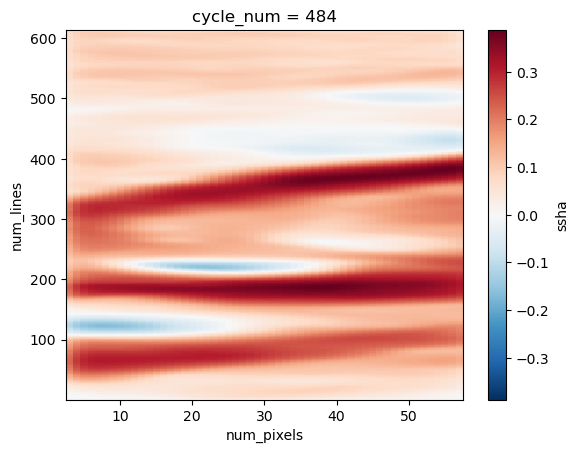

In [6]:
# h_interp = xr.open_zarr(sdir,
#                         '01-day-repeat/GulfStream/ssha_linear_%02dkm.zarr' 
#                         % (10)
                       # ).ssha.chunk({'num_pixels':-1,
                       #               'num_lines':-1}
                       #             ).interpolate_na(dim='num_pixels', method='slinear', 
                                   #     fill_value="extrapolate"
                                   #    ).interpolate_na(dim='num_lines', method='slinear', 
                                   #                     fill_value="extrapolate"
                                   #                    )
nph = 3
nlh = 1
fscale = 15
h_interp = xr.open_zarr(sdir,
                        '01-day-repeat/GulfStream/ssha_linear_%02dkm.zarr' 
                        % (fscale)
                       ).ssha.isel(num_pixels=slice(nph,-nph),
                                   num_lines=slice(nlh,-nlh)
                                  ).chunk({'num_pixels':-1,
                                           'num_lines':-1}
                      ).interpolate_na(dim='num_pixels', method='nearest', 
                                       fill_value="extrapolate"
                                      ).interpolate_na(dim='num_lines', method='nearest', 
                                                       fill_value="extrapolate"
                                                      )
h_interp.isel(cycle_num=10).plot()
h_interp

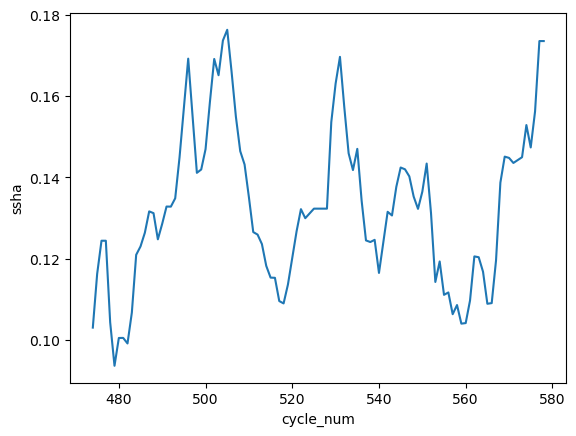

In [7]:
h_interp.mean(['num_lines','num_pixels']).plot()

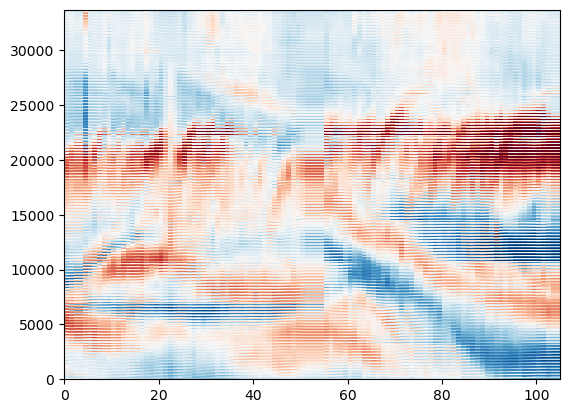

<xarray.DataArray 'ssha' (z: 33715, cycle_num: 105)>
dask.array<transpose, shape=(33715, 105), dtype=float64, chunksize=(1750, 27), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 474 475 476 477 478 ... 574 575 576 577 578
  * z           (z) object MultiIndex
  * num_lines   (z) int64 1 1 1 1 1 1 1 1 1 ... 613 613 613 613 613 613 613 613
  * num_pixels  (z) int64 3 4 5 6 7 8 9 10 11 12 ... 49 50 51 52 53 54 55 56 57

In [7]:
zchunk = 1750
h_stacked = (h_interp 
             - h_interp.mean(['num_lines','num_pixels'])
            ).stack(z=("num_lines", "num_pixels")
                          ).chunk({'z':zchunk}).fillna(0.)
# h_stacked = h_interp.stack(z=("YC", "XC")
#                           ).chunk({'z':zchunk}).fillna(0.)

fig, ax = plt.subplots()
ax.pcolormesh(h_stacked.T.values, 
              rasterized=True,  
              vmax=.4, vmin=-.4, cmap='RdBu_r')
plt.show()
h_stacked.T

In [8]:
nh = 24
window_lengths = (np.array([9, 10, 11, 30])).astype(int) # 24 hourly
step_sizes = np.array([1, 1, 1, 1])
print(window_lengths, "[days]")

[ 9 10 11 30] [days]


In [9]:
fit = False

In [11]:
# sr = 4
# svd_ranks = [sr] * len(window_lengths)
svd_ranks = [4, 4, 6, 10]
if len(svd_ranks) != len(window_lengths):
    print("######### WRONG LENGTHS #########")
suppress_growth = True
transform_method = "absolute"
# n_components_array = [2] * len(window_lengths)
global_svd_array = [False] * len(window_lengths)

dmd = mrCOSTS(
    svd_rank_array=svd_ranks,
    window_length_array=window_lengths,
    step_size_array=step_sizes,
    global_svd_array=global_svd_array,
    cluster_sweep=True,
    transform_method=transform_method,
    # pydmd_kwargs={'eig_constraints':{"imag", "conjugate_pairs"}},
    # n_components_array=n_components_array,
)

if fit:
    dmd.fit(h_stacked.values.T, 
            np.atleast_2d(np.arange(len(h_stacked.cycle_num)
                                   ) * 24.*3600.)
           )

In [10]:
fscale = 15
if fit:
    # dmd.to_netcdf(op.join(ddir, 
    #                       "SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d_fit"
    #                       % (nh,len(window_lengths))
    #                      )
    #              )
    dmd.to_netcdf(op.join(ddir, 
                          "SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d_fit_linear_%02dkm_new"
                          % (nh,len(window_lengths),fscale)
                         )
                 )
else:
    mrc = glob.glob(op.join(ddir, 
                            "SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d_fit_linear_%02dkm_new*.nc"
                            % (nh,len(window_lengths),fscale)
                           )
                   )
    print(mrc)
    dmd = mrCOSTS()
    dmd.from_netcdf(mrc)

['/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/24hourly/04_fit_linear_15km_new.window=10.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/24hourly/04_fit_linear_15km_new.window=11.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/24hourly/04_fit_linear_15km_new.window=9.nc', '/tank/spectre/tuchida/DMD/SWOT/CalVal/mrCOSTS_h/24hourly/04_fit_linear_15km_new.window=30.nc']


In [13]:
# Plot the 3rd decomposition level
n_decomp = 2
mrd = dmd.costs_array[n_decomp]

# The data for each decomposition level is built here to avoid
# reconstructing the data for each plot. If this is not done the
# plots can still be rendered but will take slightly longer.
if n_decomp == 0:
    x_iter = data
else:
    x_iter, _ = dmd.costs_array[n_decomp - 1].scale_separation(
        scale_reconstruction_kwargs=dmd._costs_recon_kwargs
    )

Text(0.5, 0.98, 'Window length=11')

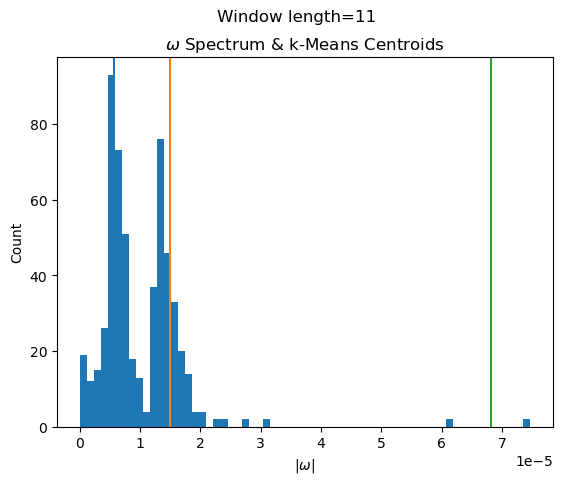

In [14]:
fig, ax = mrd.plot_omega_histogram()
fig.suptitle("Window length={}".format(mrd.window_length))

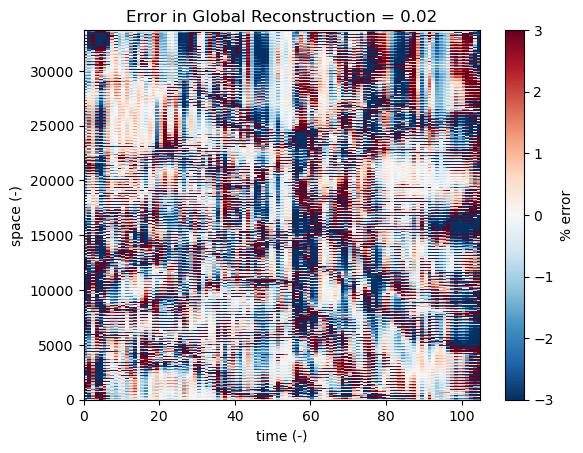

In [15]:
# Error in global reconstruction
dmd.plot_local_error(
    n_decomp, data=x_iter, 
    scale_reconstruction_kwargs=dmd._costs_recon_kwargs
)

In [11]:
dmd.multi_res_interp()
dmd._da_omega

<xarray.DataArray 'omega' (window_length: 4, window_time_means: 97, svd_rank: 10)>
array([[[            nan           +nanj,
                     nan           +nanj,
          1.42403432e-07+1.64903519e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
         -3.59135357e-08+1.72614539e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
         -8.36879888e-07+1.75045468e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        ...,
        [            nan           +nanj,
...
                     nan           +nanj],
        ...,
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj]]])
Coordinates:
  * window_time_means    (window_time_means) float64 3.456e+05 ... 8.64e+06
  * svd_rank             (svd_rank) int64 0 1 2 3 4 5 6 7 8 9
    slide                (window_length, window_time_means) float64 0.0 ... 75.0
  * window_length        (window_length) int64 9 10 11 30
    decomposition_level  (window_length) int64 0 1 2 3

fitting n_components = 4
fitting n_components = 5
fitting n_components = 6
fitting n_components = 7
fitting n_components = 8
fitting n_components = 9
fitting n_components = 10
fitting n_components = 11
fitting n_components = 12
fitting n_components = 13
fitting n_components = 14
fitting n_components = 15
fitting n_components = 16
fitting n_components = 17
fitting n_components = 18
fitting n_components = 19
fitting n_components = 20
fitting n_components = 21
Optimal silhouette score is = 10


Text(0, 0.5, 'Silhouette score (-), (1 is best, -1 is worst)')

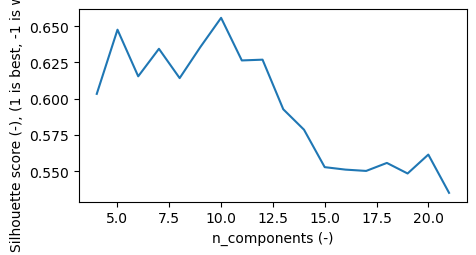

In [12]:
n_components_range = np.arange(4, 22)
scores, n_optimal = dmd.global_cluster_hyperparameter_sweep(
    n_components_range,
    transform_method="log10",
)

print("Optimal silhouette score is = {}".format(n_optimal))
plt.figure(figsize=(5, 2.5))
plt.plot(n_components_range, scores)
plt.gca().set_xlabel("n_components (-)")
plt.gca().set_ylabel("Silhouette score (-), (1 is best, -1 is worst)")

In [14]:
# n_ops = 10
cluster_centroids, omega_classes, omega_array = dmd.global_cluster_omega(
    n_optimal,
    # n_ops,
    transform_method="log10"
)
cluster_centers_periods = 1 / (10 ** (cluster_centroids) / (2 * np.pi))

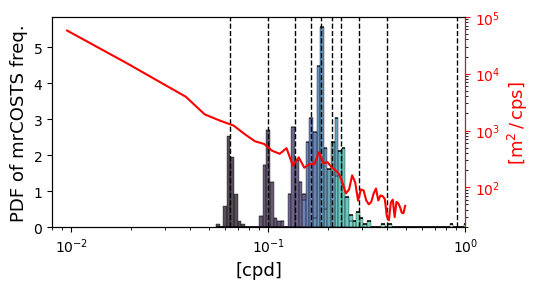

In [71]:
x_trans = (2 * np.pi / 10**omega_array / 86400.)**-1
# unique_labels, label_counts = np.unique(omega_classes, return_counts=True)
# weights = label_counts.max() / label_counts
# x_trans_labels = [x_trans[omega_classes == label] for label in unique_labels]

# weights_labels = []
# unique_labels = unique_labels.astype(int)
# for label in unique_labels:
#     ind_array = np.flatnonzero(unique_labels == label)
#     ind_list = int(ind_array)
#     w = weights[ind_array]
#     x_w = x_trans_labels[ind_list]
#     w_broadcast = np.broadcast_to(w, (x_w.shape))
#     weights_labels.append(w_broadcast)
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
cluster_centers = 1 / ((10 ** cluster_centroids) / (2 * np.pi) / 86400.)

# Make a continuous color palette with the brightest and darkest excluded
palette = sns.color_palette("mako", len(cluster_centers) + 2)
# palette = palette[1:-1]


Fh = xrft.power_spectrum(h_interp[...,::150,10::40
                         ].chunk({'cycle_num':-1}
                                ).assign_coords({'cycle_num':
                                                 np.arange(len(h_interp.cycle_num)) 
                                                 * 86400.}
                                               ), 
                         dim='cycle_num', window='hann', window_correction=True
                        ).astype(np.single)

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(5.5, 3))
ax2 = ax.twinx()
fig.set_tight_layout(True)

ax2.plot(Fh.freq_cycle_num.isel(freq_cycle_num=slice(len(Fh.freq_cycle_num)//2+1,None)
                               )*86400, 
         Fh.isel(freq_cycle_num=slice(len(Fh.freq_cycle_num)//2+1,None)
                ).mean(['num_pixels','num_lines'])*2,
         c='r', label=r"Fourier")

# ax = plt.gca()
ax.set_xscale("log")
# ax2.set_xscale("log")
ax2.set_yscale("log")
# ax.set_title(
#     "Global histogram of frequencies; Interpolated decomposition levels"
# )
# ax.set_xlabel(r"Period; $(2 \pi) / Im(|\omega|)$ [day]")

# ax.hist(
#     x=x_trans_labels,
#     bins=np.logspace(stop=np.log10((1.9e4/86400)**-1), 
#                      start=np.log10((1.5e6/86400)**-1), 
#                      num=200),
#     histtype="barstacked",
#     weights=weights_labels,
#     # alpha=.8,
# )
sns.histplot(
    # x=((10**omega_array) / (2 * np.pi) / 86400.),
    x=x_trans,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=70,
    palette=ListedColormap(palette),
    legend=False,
    ax=ax
)

ax.set_xlabel(r"[cpd]", fontsize=13)
ax.set_ylabel("PDF of mrCOSTS freq.", fontsize=13)
ax2.set_ylabel("[m$^2\,/\,$cps]", fontsize=13, c='r')

ax.set_xlim([8e-3,1e0])
# ax2.set_xlim([8e-3,1.5e1])
ax2.set_ylim([2e1,1e5])

# ax2.fill_between(np.array([1/(24.*2*3600.)*86400, 1/(24.*3600.)*86400]), 
#                  2e1, 1e5, 
#                  color='r', alpha=.15)
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

[
    ax.axvline((2 * np.pi / (10**c) / 86400)**-1, color="k", ls="--", lw=1)
    for nc, c in enumerate(cluster_centroids)
];
# ylim_bottom, ylim_top = ax.get_ylim()
# [
#     ax.text(
#         2 * np.pi / (10**c),
#         ylim_top - ylim_top * 0.1,
#         "{:4.0f}d".format(1 / (10 ** (c) / (2 * np.pi))),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centroids
# ];

# y_lim_bottom, y_lim_top = ax.get_ylim()
# [
#     ax.text(
#         c,
#         y_lim_top - y_lim_top * 0.2,
#         # "{:0.2f} Hz".format(c),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centers
# ];
plt.savefig(op.join(sdir,'Figs/SWOT_mrCOSTS_hist_%02dh-%02d_%02dkm.pdf' 
                    % (nh,len(window_lengths),fscale))
           )

In [15]:
omega_classes_list = dmd.multi_res_deterp()

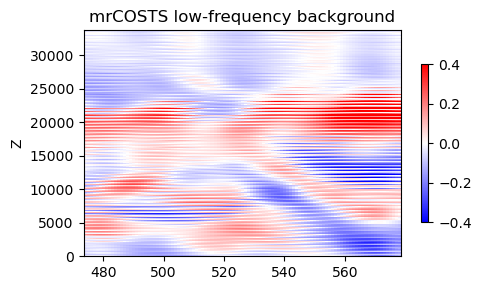

In [21]:
xr_background = dmd.get_background()

ds_global_background = xr.DataArray(xr_background, dims=h_stacked.T.dims,
                                    coords=h_stacked.T.coords
                                   ).unstack().chunk({'cycle_num':1})
ds_global_background.chunk(
#         {'lat':100, 'lon':100}
).to_dataset(name='background'
            ).to_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/background_%02dkm.zarr' 
                              % (nh, len(window_lengths), fscale)),
                              mode='w')

fig, ax = plt.subplots(figsize=(5, 3))
fig.set_tight_layout(True)
im = ax.pcolormesh(
    h_stacked.cycle_num,
    np.arange(len(h_stacked.z)), 
    xr_background, 
    vmin=-.4, vmax=.4, cmap="bwr",
    rasterized=True
)
ax.set_title("mrCOSTS low-frequency background")
ax.set_ylabel("Z")
# fig.autofmt_xdate()
fig.colorbar(im, shrink=.7)

In [22]:
xr_sep = dmd.global_scale_reconstruction()

In [66]:
(dmd.n_decompositions, 
 (dmd.ragged_omega_classes[0]>-1).shape, 
 dmd.ragged_amplitudes_array[0].shape)

(4, (97, 10), (97, 4))

In [23]:
for ncl_center, cl_center in enumerate(cluster_centers_periods):
    
    ds_xr_sep = xr.DataArray(
        xr_sep.real[:, ncl_center],
        dims=["decomp_level", "z", "cycle_num"],
        coords=[
            np.arange(len(dmd.costs_array)),
            # np.arange(n_optimal),
            h_stacked.z,
            h_stacked.cycle_num,
        ],
    )

    for dd in ds_xr_sep.decomp_level:
        if dd == 0:
            ds_global_separation = ds_xr_sep.sel(decomp_level=dd
                                                ).unstack().chunk({'cycle_num':1})
        else:
            ds_global_separation = xr.concat([ds_global_separation,
                                              ds_xr_sep.sel(decomp_level=dd
                                                  ).unstack().chunk({'cycle_num':1})
                                             ], 'decomp_level'
                                            )
    
    # ds_xr_sep.isel(decomp_level=0).sum("cluster").plot(rasterized=True)
    ds_cluster_centers = xr.DataArray(
        np.array([1 / (10 ** (cluster_centroids[ncl_center]) / (2 * np.pi)),]),
        dims=["cluster"],
        # coords=[np.arange(n_optimal)],
        coords=[np.array([ncl_center,])],
    )
    ds_cluster_centers.attrs["units"] = "s"
    ds_cluster_centers.attrs["long_name"] = "Central period of each period band"
    
    ds_global_separation = ds_global_separation.to_dataset(name="frequency_bands")
    ds_global_separation["frequency_bands"].attrs["units"] = "m"
    ds_global_separation["frequency_bands"].attrs["long_name"] = "mrCOSTS"
    
    ds_global_separation.coords["cluster_centers"] = ds_cluster_centers

    if ncl_center == 0:
        print(ds_global_separation)
        
    ds_global_separation.chunk(
                # {'time':1,'decomp_level':1}
                ).to_zarr(op.join(ddir,
    'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d_%02dkm.zarr' 
                      % (nh, len(window_lengths), ncl_center, fscale)),
                      mode='w')
    print(ncl_center)

<xarray.Dataset>
Dimensions:          (num_lines: 613, num_pixels: 55, decomp_level: 4,
                      cycle_num: 105, cluster: 1)
Coordinates:
  * num_lines        (num_lines) int64 1 2 3 4 5 6 7 ... 608 609 610 611 612 613
  * num_pixels       (num_pixels) int64 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57
  * decomp_level     (decomp_level) int64 0 1 2 3
  * cycle_num        (cycle_num) int64 474 475 476 477 478 ... 575 576 577 578
  * cluster          (cluster) int64 0
    cluster_centers  (cluster) float64 1.343e+06
Data variables:
    frequency_bands  (decomp_level, cycle_num, num_lines, num_pixels) float64 dask.array<chunksize=(1, 1, 613, 55), meta=np.ndarray>
0
1
2
3
4
5
6
7
8
9


In [24]:
xr_global_reconstruction = dmd.global_reconstruction()
da_global_reconstruction = xr.DataArray(
    data=xr_global_reconstruction.real, 
    dims=h_stacked.T.dims,
    coords=h_stacked.T.coords
).unstack().chunk({'cycle_num':1})
da_global_reconstruction.attrs["units"] = "m"
da_global_reconstruction.attrs["long_name"] = r"SWOT SSH"

In [25]:
da_global_reconstruction.chunk(
    # {'lat':100, 'lon':100}
).to_dataset(name='SSH').to_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/Total_%02dkm.zarr' 
                      % (nh, len(window_lengths), fscale)),
                      mode='w')

In [16]:
for i in range(n_optimal):
    if i == 0:
        dsc = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d_%02dkm.zarr' 
                           % (24,4,i,fscale))
                          )
    else:
        # try:
        dsc = xr.concat([dsc,xr.open_zarr(op.join(ddir,
                'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d_%02dkm.zarr' 
                               % (24,4,i,fscale)))
                            ], 'cluster')
        # except:
        #     pass
    
dsC = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/Total_%02dkm.zarr' 
                           % (24,4,fscale))
                  )
dsb = xr.open_zarr(op.join(ddir,
            'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/background_%02dkm.zarr' 
                           % (24,4,fscale))
                  )
dsc

<xarray.Dataset>
Dimensions:          (cluster: 10, cycle_num: 105, decomp_level: 4,
                      num_lines: 613, num_pixels: 55)
Coordinates:
  * cluster          (cluster) int64 0 1 2 3 4 5 6 7 8 9
    cluster_centers  (cluster) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * cycle_num        (cycle_num) int64 474 475 476 477 478 ... 575 576 577 578
  * decomp_level     (decomp_level) int64 0 1 2 3
  * num_lines        (num_lines) int64 1 2 3 4 5 6 7 ... 608 609 610 611 612 613
  * num_pixels       (num_pixels) int64 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57
Data variables:
    frequency_bands  (cluster, decomp_level, cycle_num, num_lines, num_pixels) float64 dask.array<chunksize=(1, 1, 1, 613, 55), meta=np.ndarray>

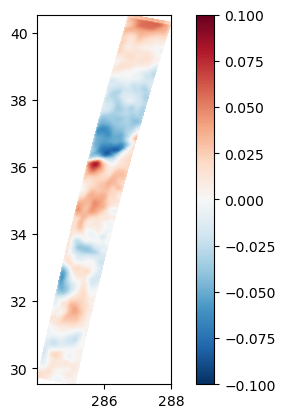

########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(0)
Coordinates:
    decomp_level  int64 0
########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(1)
Coordinates:
    decomp_level  int64 1
########## TIME: 4


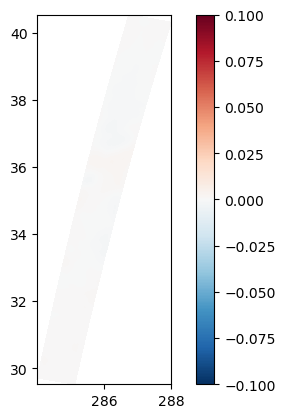

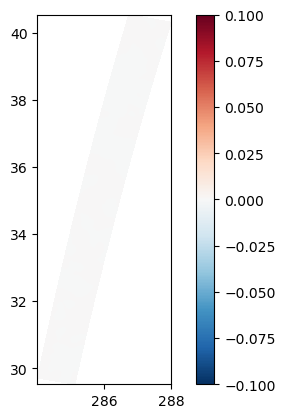

########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(0)
Coordinates:
    decomp_level  int64 0
########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(1)
Coordinates:
    decomp_level  int64 1
########## TIME: 24


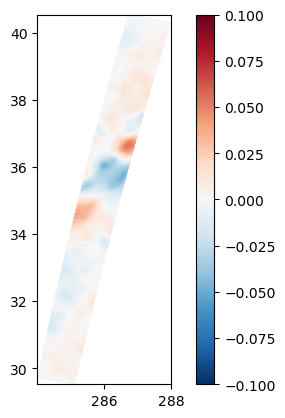

########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(0)
Coordinates:
    decomp_level  int64 0
########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(1)
Coordinates:
    decomp_level  int64 1
########## TIME: 44


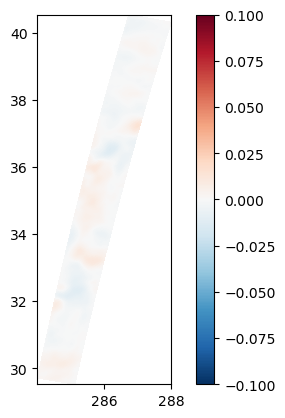

########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(0)
Coordinates:
    decomp_level  int64 0
########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(1)
Coordinates:
    decomp_level  int64 1
########## TIME: 64


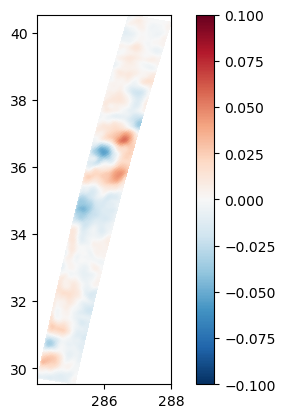

########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(0)
Coordinates:
    decomp_level  int64 0
########## DECOMP: <xarray.DataArray 'decomp_level' ()>
array(1)
Coordinates:
    decomp_level  int64 1
########## TIME: 84


In [19]:
for tt in np.arange(4,len(dsc.cycle_num)-4,20):

    dsGS = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                % dsc.cycle_num[tt].values)
                       ).isel(num_pixels=slice(npix+nph,-npix-nph),
                              num_lines=slice(nlin+nlh,-nlin-nlh)
                             )
    
    for i in dsc.decomp_level.isel(decomp_level=slice(None,2)):
        
        for j in dsc.cluster.isel(cluster=slice(-4,None)):
            if dsc.frequency_bands.sel(decomp_level=i, cluster=j
                                      ).isel(cycle_num=tt).sum() != 0.:
                fig, ax = plt.subplots()
                try:
                    im = ax.pcolor(dsGS.longitude, 
                              dsGS.latitude,
                              dsc.frequency_bands.sel(decomp_level=i, cluster=j
                                           ).isel(cycle_num=tt),
                              rasterized=True,
                              cmap='RdBu_r', vmin=-.1, vmax=.1,
                             )
                except:
                    im = ax.pcolor(dsGS.longitude.sel(pass_num=9), 
                              dsGS.latitude.sel(pass_num=9),
                              dsc.frequency_bands.sel(decomp_level=i, cluster=j
                                                     ).isel(cycle_num=tt),
                              rasterized=True,
                              cmap='RdBu_r', vmin=-.1, vmax=.1,
                             )
                # im = ax.pcolor(dsc.XC, 
                #               dsc.YC,
                #               dsc.frequency_bands.sel(decomp_level=i, cluster=j
                #                            ).isel(cycle_num=tt),
                #               rasterized=True,
                #               cmap='RdBu_r', vmin=-.1, vmax=.1,
                #              )
                ax.set_aspect('equal')
                fig.colorbar(im)
                plt.show()
            
        print("########## DECOMP:",i)
    print("########## TIME:",tt)

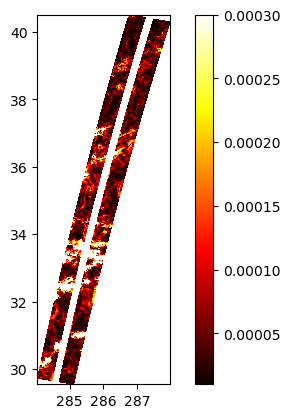

<xarray.Dataset>
Dimensions:  (YF: 611, XF: 53, YG: 612, XC: 55, YC: 613, XG: 54)
Coordinates:
  * YF       (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * XF       (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YG       (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 607.5 608.5 609.5 610.5 611.5
  * XC       (XC) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
  * YC       (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * XG       (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
Data variables:
    vort     (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    strain   (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    u        (YG, XC) float64 dask.array<chunksize=(306, 55), meta=np.ndarray>
    v        (YC, XG) float64 dask.array<chunksize=(307, 54), meta=np.ndarray>


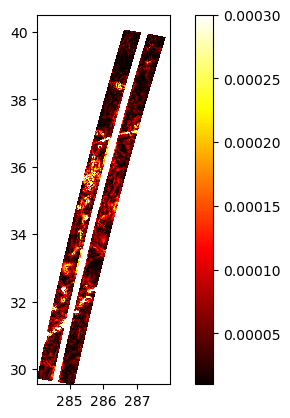

<xarray.Dataset>
Dimensions:  (YF: 611, XF: 53, YG: 612, XC: 55, YC: 613, XG: 54)
Coordinates:
  * YF       (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * XF       (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YG       (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 607.5 608.5 609.5 610.5 611.5
  * XC       (XC) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
  * YC       (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * XG       (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
Data variables:
    vort     (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    strain   (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    u        (YG, XC) float64 dask.array<chunksize=(306, 55), meta=np.ndarray>
    v        (YC, XG) float64 dask.array<chunksize=(307, 54), meta=np.ndarray>


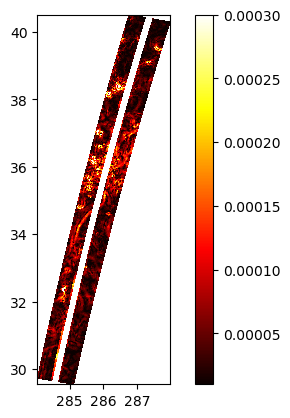

<xarray.Dataset>
Dimensions:  (YF: 611, XF: 53, YG: 612, XC: 55, YC: 613, XG: 54)
Coordinates:
  * YF       (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * XF       (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YG       (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 607.5 608.5 609.5 610.5 611.5
  * XC       (XC) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
  * YC       (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * XG       (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
Data variables:
    vort     (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    strain   (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    u        (YG, XC) float64 dask.array<chunksize=(306, 55), meta=np.ndarray>
    v        (YC, XG) float64 dask.array<chunksize=(307, 54), meta=np.ndarray>


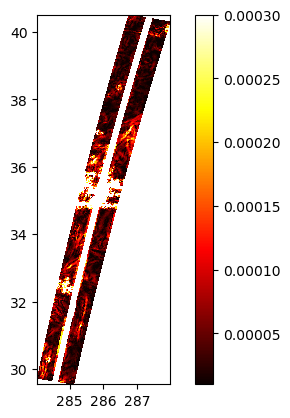

<xarray.Dataset>
Dimensions:  (YF: 611, XF: 53, YG: 612, XC: 55, YC: 613, XG: 54)
Coordinates:
  * YF       (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * XF       (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YG       (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 607.5 608.5 609.5 610.5 611.5
  * XC       (XC) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
  * YC       (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * XG       (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
Data variables:
    vort     (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    strain   (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    u        (YG, XC) float64 dask.array<chunksize=(306, 55), meta=np.ndarray>
    v        (YC, XG) float64 dask.array<chunksize=(307, 54), meta=np.ndarray>


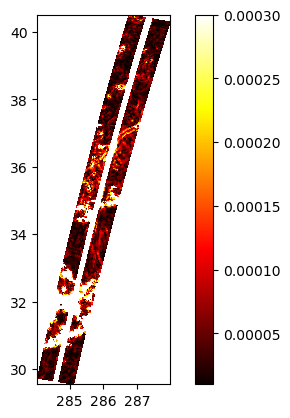

<xarray.Dataset>
Dimensions:  (YF: 611, XF: 53, YG: 612, XC: 55, YC: 613, XG: 54)
Coordinates:
  * YF       (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * XF       (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YG       (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 607.5 608.5 609.5 610.5 611.5
  * XC       (XC) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
  * YC       (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * XG       (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
Data variables:
    vort     (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    strain   (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    u        (YG, XC) float64 dask.array<chunksize=(306, 55), meta=np.ndarray>
    v        (YC, XG) float64 dask.array<chunksize=(307, 54), meta=np.ndarray>


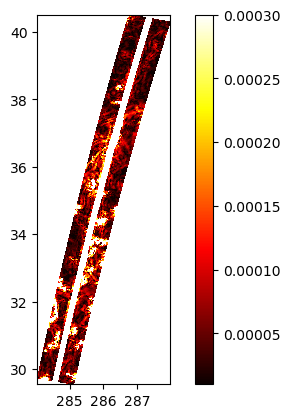

<xarray.Dataset>
Dimensions:  (YF: 611, XF: 53, YG: 612, XC: 55, YC: 613, XG: 54)
Coordinates:
  * YF       (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * XF       (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YG       (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 607.5 608.5 609.5 610.5 611.5
  * XC       (XC) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
  * YC       (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * XG       (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
Data variables:
    vort     (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    strain   (YF, XF) float64 dask.array<chunksize=(305, 53), meta=np.ndarray>
    u        (YG, XC) float64 dask.array<chunksize=(306, 55), meta=np.ndarray>
    v        (YC, XG) float64 dask.array<chunksize=(307, 54), meta=np.ndarray>


In [68]:
for tt in np.arange(len(dsc.cycle_num)):

    try:
        dsGS = xr.open_zarr(op.join(sdir,
                                    '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                    % dsc.cycle_num[tt].values)
                           ).isel(num_pixels=slice(npix+nph,-npix-nph),
                                  num_lines=slice(nlin+nlh,-nlin-nlh)
                                 ).sel(pass_num=9)
    except:
        dsGS = xr.open_zarr(op.join(sdir,
                                    '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                    % dsc.cycle_num[tt].values)
                           ).isel(num_pixels=slice(npix+nph,-npix-nph),
                                  num_lines=slice(nlin+nlh,-nlin-nlh)
                                 )
    
    # if tt == 0:
        # yy, xx = np.mgrid[dsGS.latitude.min(skipna=True).values:dsGS.latitude.max(skipna=True).values:np.abs(dsGS.latitude.diff('num_lines').min(skipna=True).values),
        #           dsGS.longitude.min(skipna=True).values:dsGS.longitude.max(skipna=True).values:np.abs(dsGS.longitude.diff('num_pixels').min(skipna=True).values)
        #          ]
        # lon = griddata((dsGS.latitude.values.flatten(),dsGS.longitude.values.flatten()), 
        #                dsGS.longitude.values.flatten(), 
        #                (yy, xx), method='linear'
        #               )
        # lat = griddata((dsGS.latitude.values.flatten(),dsGS.longitude.values.flatten()), 
        #                dsGS.latitude.values.flatten(), 
        #                (yy, xx), method='linear'
        #               )
        # ssh = griddata((dsGS.latitude.values.flatten(),dsGS.longitude.values.flatten()), 
        #                low.values.flatten(), 
        #                (yy, xx), method='linear'
        #               )

    dx = gsw.distance(dsGS.longitude, dsGS.latitude, p=0, axis=-1)
    dy = gsw.distance(dsGS.longitude, dsGS.latitude, p=0, axis=0)

    cori = gsw.f(dsGS.latitude).values

    u = -(grav * np.diff(dsGS.ssha_karin_2_filtered.values,axis=0) 
          / (.5*(cori[1:] + cori[:-1])) / dy)
    v = (grav * np.diff(dsGS.ssha_karin_2_filtered.values,axis=1) 
         / (.5*(cori[:,1:] + cori[:,:-1])) / dx)

    u_x = np.diff(u,axis=1) / (.5*(dx[1:] + dx[:-1]))
    v_y = np.diff(v,axis=0) / (.5*(dy[:,1:] + dy[:,:-1]))
    u_x = .25*(u_x[:-1,:-1] + u_x[1:,:-1] + u_x[1:,1:] + u_x[:-1,1:])
    v_y = .25*(v_y[:-1,:-1] + v_y[1:,:-1] + v_y[1:,1:] + v_y[:-1,1:])

    u_y = (np.diff(u,axis=0) / (.5*(dy[1:] + dy[:-1])))[:,1:-1]
    v_x = (np.diff(v,axis=1) / (.5*(dx[:,1:] + dx[:,:-1])))[1:-1]
        
    vort = v_x - u_y

    sn = u_x - v_y
    ss = v_x + u_y
    strain = np.sqrt(sn**2 + ss**2)

    dsave = xr.DataArray(vort, dims=['YF','XF'], 
                         coords={'YF':dsGS.num_lines.values[1:-1],
                                 'XF':dsGS.num_pixels.values[1:-1]}
                        ).to_dataset(name='vort')
    dsave['strain'] = xr.DataArray(strain, dims=['YF','XF'], 
                                   coords={'YF':dsGS.num_lines.values[1:-1],
                                           'XF':dsGS.num_pixels.values[1:-1]}
                                  )
    dsave['u'] = xr.DataArray(u, dims=['YG','XC'], 
                              coords={'YG':.5*(dsGS.num_lines.values[1:] 
                                               + dsGS.num_lines.values[:-1]),
                                      'XC':dsGS.num_pixels.values}
                             )
    dsave['v'] = xr.DataArray(v, dims=['YC','XG'], 
                              coords={'YC':dsGS.num_lines.values,
                                      'XG':.5*(dsGS.num_pixels.values[1:] 
                                               + dsGS.num_pixels.values[:-1])}
                             )
    # dsave.coords['lon'] = xr.DataArray(lon, dims=['YC','XC'],
    #                                        coords={'YC':np.mean(dsGS.latitude, axis=1),
    #                                                'XC':np.mean(dsGS.longitude, axis=0)})
    # dsave.coords['lat'] = xr.DataArray(lat, dims=['YC','XC'],
    #                                        coords={'YC':np.mean(dsGS.latitude, axis=1),
    #                                                'XC':np.mean(dsGS.longitude, axis=0)})
    if tt % 20 == 0:
        fig, ax = plt.subplots()
        im = ax.pcolor(dsGS.longitude[1:-1,1:-1], 
                       dsGS.latitude[1:-1,1:-1],
                       dsave.strain,
                       rasterized=True,
                       cmap='hot', vmin=1e-5, vmax=3e-4,
                      )
        ax.set_aspect('equal')
        fig.colorbar(im)
        plt.show()
        print(dsave)
    dsave.chunk({'YC':100,'XC':100,'YG':100,'XG':100,'YF':100,'XF':100}
               ).to_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/%02dhourly/vort-strain/raw/cycle_num%03d.zarr' 
                                 % (24,dsc.cycle_num[tt].values)
                                ), mode='w')
    dsave.close()

In [20]:
n_cluster = n_optimal - 4
low = (dsb.background 
       + dsc.frequency_bands.isel(cluster=slice(None,n_cluster)
                                 ).sum(['cluster','decomp_level'])
      )
array = xr.open_zarr(sdir,
                     '01-day-repeat/GulfStream/ssha_linear_%02dkm.zarr' 
                     % (fscale)
                    ).ssha.isel(num_pixels=slice(nph,-nph),
                                num_lines=slice(nlh,-nlh)
                               ).to_masked_array()
mask_low = xr.DataArray(~array.mask, dims=low.dims,
                        coords=low.coords
                       )
low = low.where(mask_low)

tot = xr.open_zarr(op.join(ddir,
                   'SWOT/CalVal/mrCOSTS_h/%02dhourly/%02d-recons/Total_%02dkm.zarr' 
                   % (nh, len(window_lengths), fscale))
                  ).SSH
tot = tot.where(mask_low)
low

<xarray.DataArray (cycle_num: 105, num_lines: 613, num_pixels: 55)>
dask.array<where, shape=(105, 613, 55), dtype=float64, chunksize=(1, 613, 55), chunktype=numpy.ndarray>
Coordinates:
  * cycle_num   (cycle_num) int64 474 475 476 477 478 ... 574 575 576 577 578
  * num_lines   (num_lines) int64 1 2 3 4 5 6 7 ... 607 608 609 610 611 612 613
  * num_pixels  (num_pixels) int64 3 4 5 6 7 8 9 10 ... 50 51 52 53 54 55 56 57

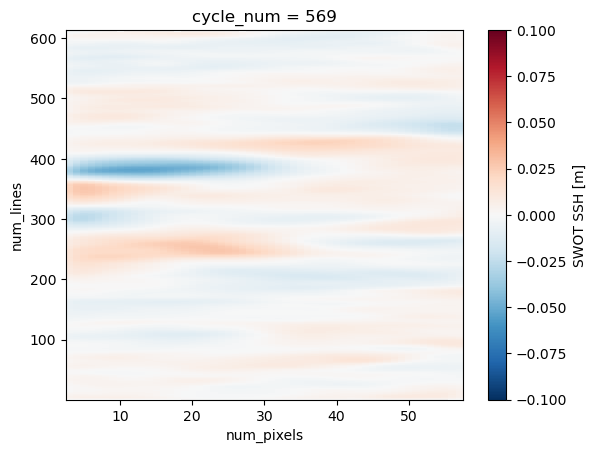

In [38]:
(tot-low).isel(cycle_num=-10).plot(vmax=1e-1)

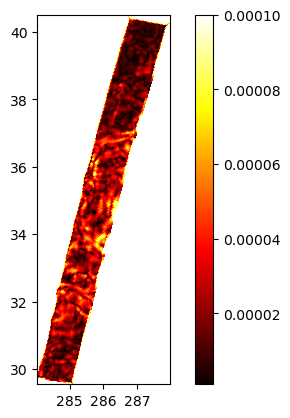

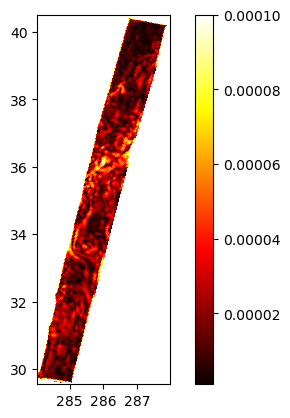

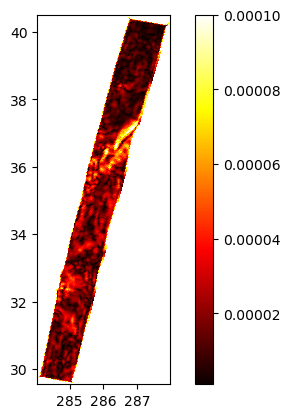

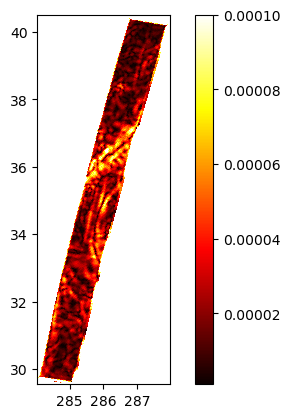

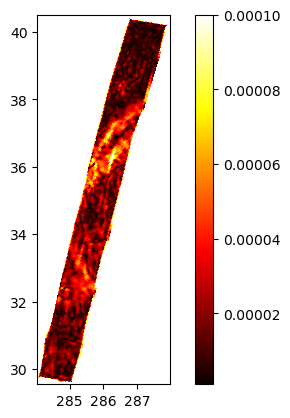

<xarray.Dataset>
Dimensions:    (YF: 611, XF: 53, cycle_num: 105, YG: 612, XC: 55, YC: 613,
                XG: 54)
Coordinates:
  * YF         (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * XF         (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YG         (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 608.5 609.5 610.5 611.5
  * XC         (XC) int64 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
  * YC         (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * XG         (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
  * cycle_num  (cycle_num) int64 474 475 476 477 478 479 ... 574 575 576 577 578
Data variables:
    vort       (cycle_num, YF, XF) float64 nan nan nan nan ... nan nan nan nan
    strain     (cycle_num, YF, XF) float64 nan nan nan nan ... nan nan nan nan
    u          (cycle_num, YG, XC) float64 nan nan nan nan ... nan nan nan nan
    v          (cycle_num, YC, XG) float64 nan nan nan nan 

In [39]:
ic = 1
for cc in low.cycle_num:
    try:
        dsGS = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                            % cc.values)
                   ).isel(num_pixels=slice(npix+nph,-npix-nph),
                          num_lines=slice(nlin+nlh,-nlin-nlh)
                         ).sel(pass_num=9)
    except:
        dsgs = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                            % cc.values)
                   ).isel(num_pixels=slice(npix+nph,-npix-nph),
                          num_lines=slice(nlin+nlh,-nlin-nlh)
                         )
        if dsgs.pass_num.values == 9:
            dsGS = dsgs.copy()

    dx = gsw.distance(dsGS.longitude, dsGS.latitude, p=0, axis=1
                     ).values
    dy = gsw.distance(dsGS.longitude, dsGS.latitude, p=0, axis=0
                     ).values
    # xx, yy = np.meshgrid(low.XC, low.YC)
    # dx = gsw.distance(xx, yy, p=0, axis=-1
    #                  )
    # dy = gsw.distance(xx, yy, p=0, axis=0
    #                  )
    
    cori = gsw.f(dsGS.latitude).values
    # cori = gsw.f(low.YC).values[:,np.newaxis]

    u = -(grav * np.diff(low.sel(cycle_num=cc).values,axis=0) 
          / (.5*(cori[1:] + cori[:-1])) / dy)
    v = (grav * np.diff(low.sel(cycle_num=cc).values,axis=1) 
         / (.5*(cori[:,1:] + cori[:,:-1])) / dx)
    # v = (grav * np.diff(low.sel(cycle_num=cc).values,axis=1) 
    #      / cori / dx)
    
    u_x = np.diff(u,axis=1) / (.5*(dx[1:] + dx[:-1]))
    v_y = np.diff(v,axis=0) / (.5*(dy[:,1:] + dy[:,:-1]))
    u_x = .25 * (u_x[...,:-1,:-1] + u_x[...,1:,:-1] 
                 + u_x[...,1:,1:] + u_x[...,:-1,1:]
                )
    v_y = .25 * (v_y[...,:-1,:-1] + v_y[...,1:,:-1] 
                 + v_y[...,1:,1:] + v_y[...,:-1,1:]
                )
    
    u_y = (np.diff(u,axis=0) 
           / (.5*(dy[1:] + dy[:-1]))
          )[:,1:-1]
    v_x = (np.diff(v,axis=1) 
           / (.5*(dx[:,1:] + dx[:,:-1]))
          )[1:-1]
            
    vort = v_x - u_y
    
    sn = u_x - v_y
    ss = v_x + u_y
    strain = np.sqrt(sn**2 + ss**2)

    if cc == low.cycle_num[0]:
        U = xr.DataArray(u, dims=['YG','XC'], 
                         coords={'YG':.5*(dsGS.num_lines.values[1:] 
                                          + dsGS.num_lines.values[:-1]),
                                 'XC':dsGS.num_pixels.values}
                        )
        V = xr.DataArray(v, dims=['YC','XG'], 
                         coords={'YC':dsGS.num_lines.values,
                                 'XG':.5*(dsGS.num_pixels.values[1:] 
                                          + dsGS.num_pixels.values[:-1])}
                        )
        zeta = xr.DataArray(vort, dims=['YF','XF'], 
                            coords={'YF':dsGS.num_lines.values[1:-1],
                                    'XF':dsGS.num_pixels.values[1:-1]}
                           )
        alpha = xr.DataArray(strain, dims=['YF','XF'], 
                             coords={'YF':dsGS.num_lines.values[1:-1],
                                     'XF':dsGS.num_pixels.values[1:-1]}
                            )
        # U = xr.DataArray(u, dims=['YG','XC'], 
        #                  coords={'YG':.5*(low.YC.values[1:] 
        #                                   + low.YC.values[:-1]),
        #                          'XC':low.XC.values}
        #                 )
        # V = xr.DataArray(v, dims=['YC','XG'], 
        #                  coords={'YC':low.YC.values,
        #                          'XG':.5*(low.XC.values[1:] 
        #                                   + low.XC.values[:-1])}
        #                 )
        # zeta = xr.DataArray(vort, dims=['YF','XF'], 
        #                     coords={'YF':low.YC.values[1:-1],
        #                             'XF':low.XC.values[1:-1]}
        #                    )
        # alpha = xr.DataArray(strain, dims=['YF','XF'], 
        #                      coords={'YF':low.YC.values[1:-1],
        #                              'XF':low.XC.values[1:-1]}
        #                     )
    else:
        U = xr.concat([U, xr.DataArray(u, dims=['YG','XC'], 
                          coords={'YG':.5*(dsGS.num_lines.values[1:] 
                                           + dsGS.num_lines.values[:-1]),
                                  'XC':dsGS.num_pixels.values}
                         )
                      ],'cycle_num')
        V = xr.concat([V, xr.DataArray(v, dims=['YC','XG'], 
                          coords={'YC':dsGS.num_lines.values,
                                  'XG':.5*(dsGS.num_pixels.values[1:] 
                                           + dsGS.num_pixels.values[:-1])}
                         )
                      ], 'cycle_num')
        zeta = xr.concat([zeta, xr.DataArray(vort, dims=['YF','XF'], 
                                 coords={'YF':dsGS.num_lines.values[1:-1],
                                         'XF':dsGS.num_pixels.values[1:-1]}
                                )
                         ], 'cycle_num')
        alpha = xr.concat([alpha, xr.DataArray(strain, dims=['YF','XF'], 
                                   coords={'YF':dsGS.num_lines.values[1:-1],
                                           'XF':dsGS.num_pixels.values[1:-1]}
                                  )
                          ], 'cycle_num')
        # U = xr.concat([U, xr.DataArray(u, dims=['YG','XC'], 
        #                   coords={'YG':.5*(low.YC.values[1:] 
        #                                    + low.YC.values[:-1]),
        #                           'XC':low.XC.values}
        #                  )
        #               ],'cycle_num')
        # V = xr.concat([V, xr.DataArray(v, dims=['YC','XG'], 
        #                   coords={'YC':low.YC.values,
        #                           'XG':.5*(low.XC.values[1:] 
        #                                    + low.XC.values[:-1])}
        #                  )
        #               ], 'cycle_num')
        # zeta = xr.concat([zeta, xr.DataArray(vort, dims=['YF','XF'], 
        #                          coords={'YF':low.YC.values[1:-1],
        #                                  'XF':low.XC.values[1:-1]}
        #                         )
        #                  ], 'cycle_num')
        # alpha = xr.concat([alpha, xr.DataArray(strain, dims=['YF','XF'], 
        #                            coords={'YF':low.YC.values[1:-1],
        #                                    'XF':low.XC.values[1:-1]}
        #                           )
        #                   ], 'cycle_num')

    if ic % 20 == 0:
        fig, ax = plt.subplots()
        im = ax.pcolor(
                       dsGS.longitude[1:-1,1:-1], 
                       dsGS.latitude[1:-1,1:-1],
                       # low.XC[1:-1],
                       # low.YC[1:-1],
                       alpha.isel(cycle_num=ic-1),
                       rasterized=True,
                       cmap='hot', vmin=1e-6, vmax=1e-4,
                      )
        ax.set_aspect('equal')
        fig.colorbar(im)
        plt.show()
    ic += 1

    del vort, strain, u, v

dsave = zeta.to_dataset(name='vort')
dsave['strain'] = alpha
dsave['u'] = U
dsave['v'] = V
# dsave.coords['lon'] = xr.DataArray(lon, dims=['YC','XC'],
#                                    coords={'YC':np.mean(yy, axis=1),
#                                            'XC':np.mean(xx, axis=0)})
# dsave.coords['lat'] = xr.DataArray(lat, dims=['YC','XC'],
#                                    coords={'YC':np.mean(yy, axis=1),
#                                            'XC':np.mean(xx, axis=0)})
dsave.coords['cycle_num'] = low.cycle_num
# dsave.strain.isel(cycle_num=3).plot(vmax=3e-4, rasterized=True)
# plt.show()
print(dsave)
dsave.chunk({'YC':100,'XC':100,'YG':100,'XG':100,'YF':100,'XF':100}
           ).to_zarr(op.join(ddir,
                        'SWOT/CalVal/mrCOSTS_h/%02dhourly/vort-strain/%02d-slow%02d_%02dkm.zarr' 
                             % (24,len(window_lengths),n_cluster,fscale)
                            ), mode='w')
dsave.close()

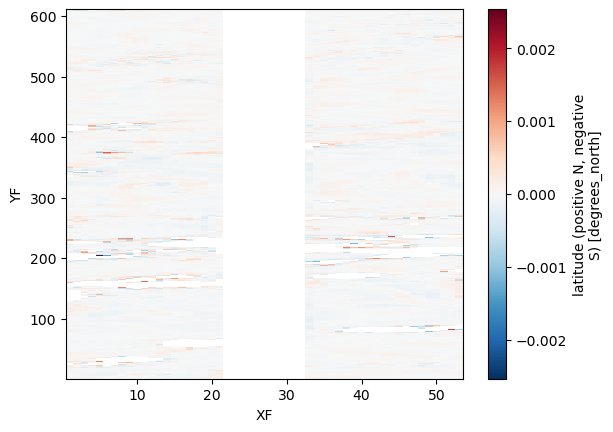

<xarray.Dataset>
Dimensions:    (XC: 55, XF: 53, XG: 54, YC: 613, YF: 611, YG: 612,
                cycle_num: 102)
Coordinates:
  * XC         (XC) int64 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
  * XF         (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * XG         (XG) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 49.5 50.5 51.5 52.5 53.5
  * YC         (YC) int64 0 1 2 3 4 5 6 7 8 ... 605 606 607 608 609 610 611 612
  * YF         (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * YG         (YG) float64 0.5 1.5 2.5 3.5 4.5 ... 608.5 609.5 610.5 611.5
  * cycle_num  (cycle_num) int64 474 475 476 477 478 479 ... 574 575 576 577 578
Data variables:
    strain     (cycle_num, YF, XF) float64 dask.array<chunksize=(1, 100, 53), meta=np.ndarray>
    u          (cycle_num, YG, XC) float64 dask.array<chunksize=(1, 100, 55), meta=np.ndarray>
    v          (cycle_num, YC, XG) float64 dask.array<chunksize=(1, 100, 54), meta=np.ndarray>
    vort       (cycle_num, YF, XF) float64 dask.array<chunksize=(1, 100, 53), meta=np.ndarray>

In [21]:
for cc in ds.cycle_num:
    if cc == ds.cycle_num[0]:
        dsGS = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                            % cc.values)
                   ).isel(num_pixels=slice(npix+nph,-npix-nph),
                          num_lines=slice(nlin+nlh,-nlin-nlh)
                         ).sel(pass_num=9)
        SSHa_raw = xr.DataArray(dsGS.ssha_karin_2_filtered.data[np.newaxis], 
                            dims=['cycle_num','num_lines','num_pixels'],
                            coords={'cycle_num':np.array([cc.values]),
                                    'num_lines':dsGS.num_lines.data,
                                    'num_pixels':dsGS.num_pixels.data})
        dsi = xr.open_zarr(op.join(sdir,
                              '01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                              % cc.values)
                           ).isel(num_pixels=slice(npix+nph,-npix-nph),
                                  num_lines=slice(nlin+nlh,-nlin-nlh)
                                 ).sel(pass_num=9)
        SSHa_interp = xr.DataArray(dsi.ssha.data[np.newaxis], 
                            dims=['cycle_num','num_lines','num_pixels'],
                            coords={'cycle_num':np.array([cc.values]),
                                    'num_lines':dsGS.num_lines.data,
                                    'num_pixels':dsGS.num_pixels.data})
        dvs_raw = xr.open_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/%02dhourly/vort-strain/raw/cycle_num%03d.zarr' 
                                 % (24,cc.values)
                                ))
        dvs_raw.vort.plot()
        plt.show()
    else:
        try:
            dsgs = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                % cc.values)
                       ).isel(num_pixels=slice(npix+nph,-npix-nph),
                              num_lines=slice(nlin+nlh,-nlin-nlh)
                             ).sel(pass_num=9)
            dsGS = xr.concat([dsGS,dsgs], 'cycle_num')
            SSHa_raw = xr.concat([SSHa_raw,
                                  xr.DataArray(dsgs.ssha_karin_2_filtered.data[np.newaxis], 
                                    dims=['cycle_num','num_lines','num_pixels'],
                                    coords={'cycle_num':np.array([cc.values]),
                                            'num_lines':dsgs.num_lines.data,
                                            'num_pixels':dsgs.num_pixels.data})
                                 ], 'cycle_num')
            dsi = xr.open_zarr(op.join(sdir,
                               '01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                               % cc.values)
                              ).isel(num_pixels=slice(npix+nph,-npix-nph),
                                     num_lines=slice(nlin+nlh,-nlin-nlh)
                                    ).sel(pass_num=9)
            SSHa_interp = xr.concat([SSHa_interp, xr.DataArray(dsi.ssha.data[np.newaxis], 
                                      dims=['cycle_num','num_lines','num_pixels'],
                                      coords={'cycle_num':np.array([cc.values]),
                                                'num_lines':dsgs.num_lines.data,
                                                'num_pixels':dsgs.num_pixels.data})
                                    ], 'cycle_num')
            dvs_raw = xr.concat([dvs_raw, xr.open_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/%02dhourly/vort-strain/raw/cycle_num%03d.zarr' 
                                 % (24,cc.values)
                                ))
                                ], 'cycle_num')
            dsgs.close()
        except:
            dsgs = xr.open_zarr(op.join(sdir,
                                '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                                % cc.values)
                               ).isel(num_pixels=slice(npix+nph,-npix-nph),
                                      num_lines=slice(nlin+nlh,-nlin-nlh)
                                     )
            if dsgs.pass_num.values == 9:
                dsGS = xr.concat([dsGS,dsgs], 'cycle_num')
                SSHa_raw = xr.concat([SSHa_raw,
                                  xr.DataArray(dsgs.ssha_karin_2_filtered.data[np.newaxis], 
                                    dims=['cycle_num','num_lines','num_pixels'],
                                    coords={'cycle_num':np.array([cc.values]),
                                            'num_lines':dsgs.num_lines.data,
                                            'num_pixels':dsgs.num_pixels.data})
                                 ], 'cycle_num')
                dsi = xr.open_zarr(op.join(sdir,
                              '01-day-repeat/GulfStream/Cyc-num%03d_linearfiltered.zarr' 
                              % cc.values)
                           ).isel(num_pixels=slice(npix+nph,-npix-nph),
                                  num_lines=slice(nlin+nlh,-nlin-nlh)
                                 )
                SSHa_interp = xr.concat([SSHa_interp, 
                                  xr.DataArray(dsi.ssha.data[np.newaxis], 
                                      dims=['cycle_num','num_lines','num_pixels'],
                                      coords={'cycle_num':np.array([cc.values]),
                                              'num_lines':dsgs.num_lines.data,
                                              'num_pixels':dsgs.num_pixels.data})
                                ], 'cycle_num')
                dvs_raw = xr.concat([dvs_raw, 
                                     xr.open_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/%02dhourly/vort-strain/raw/cycle_num%03d.zarr' 
                                     % (24,cc.values)
                                    ))
                                    ], 'cycle_num')
            dsgs.close()
    dsi.close()

dvs_raw.coords['cycle_num'] = SSHa_interp.cycle_num
dvs = xr.open_zarr(op.join(ddir,
                    'SWOT/CalVal/mrCOSTS_h/%02dhourly/vort-strain/%02d-slow%02d_%02dkm.zarr' 
                           % (24,len(window_lengths),n_cluster,fscale)
                          ))
dvs_raw

In [106]:
for cc in H_interp.cycle_num:

    try:
        dsGS = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                            % cc.values)
                   ).isel(num_pixels=slice(npix+nph,-npix-nph),
                          num_lines=slice(nlin+nlh,-nlin-nlh)
                         ).sel(pass_num=9)
    except:
        dsgs = xr.open_zarr(op.join(sdir,
                            '01-day-repeat/GulfStream/Cyc-num%03d.zarr' 
                            % cc.values)
                   ).isel(num_pixels=slice(npix+nph,-npix-nph),
                          num_lines=slice(nlin+nlh,-nlin-nlh)
                         )
        if dsgs.pass_num.values == 9:
            dsGS = dsgs.copy()
            dsgs.close()

    yy, xx = np.mgrid[dsGS.latitude.min(skipna=True).values:dsGS.latitude.max(skipna=True).values:np.abs(dsGS.latitude.diff('num_lines').mean(skipna=True).values),
                  dsGS.longitude.min(skipna=True).values:dsGS.longitude.max(skipna=True).values:np.abs(dsGS.longitude.diff('num_pixels').mean(skipna=True).values)
                 ]
    # lon = griddata((dsGS.latitude.values.flatten(),
    #                 dsGS.longitude.values.flatten()), 
    #                 dsGS.longitude.values.flatten(), 
    #                (yy, xx), method='linear'
    #               )
    # lat = griddata((dsGS.latitude.values.flatten(),
    #                 dsGS.longitude.values.flatten()), 
    #                 dsGS.latitude.values.flatten(), 
    #                (yy, xx), method='linear'
    #               )
    method = 'linear'
    ssh = xr.DataArray(griddata((dsGS.latitude.values.flatten(),
                    dsGS.longitude.values.flatten()), 
                    H_interp.sel(cycle_num=cc).values.flatten(), 
                   (yy, xx), method=method
                  )[np.newaxis,:,:], dims=['cycle_num','YC','XC'],
                       coords={'cycle_num':np.array([cc.values,]),
                               'YC':np.mean(yy, axis=1),
                               'XC':np.mean(xx, axis=0)}
                      )

    if cc == H_interp.cycle_num[0]:
        sshl = ssh
    else:
        sshl = xr.concat([sshl, ssh], 'cycle_num')
    del ssh

# sshl.coords['cycle_num'] = H_interp.cycle_num
dsave = sshl.to_dataset(name='ssha')
dsave.to_zarr(op.join(sdir,
                      '01-day-repeat/GulfStream/ssha_'+method+'_lat-lon.zarr' 
                     ), mode='w'
             )
dsave.close()

NameError: name 'H_interp' is not defined

In [22]:
array = SSHa_interp.to_masked_array()
mask_interp = xr.DataArray(~array.mask,
                           dims=SSHa_interp.dims,
                           coords=SSHa_interp.coords
                          )
array = SSHa_raw.to_masked_array()
mask_raw = xr.DataArray(~array.mask,
                        dims=SSHa_raw.dims,
                        coords=SSHa_raw.coords
                       )
# SSHa_lalo = xr.open_zarr(op.join(sdir,
#                       '01-day-repeat/GulfStream/ssha_'+method+'_lat-lon.zarr' 
#                       )
#                         ).ssha
# SSHa_lalo = SSHa_lalo.where(SSHa_lalo!=0.)
mask_interp

<xarray.DataArray (cycle_num: 102, num_lines: 613, num_pixels: 55)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
...
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * cycle_num   (cycle_num) int64 474 475 476 477 478 ... 574 575 576 577 578
  * num_lines   (num_lines) int64 0 1 2 3 4 5 6 ... 606 607 608 609 610 611 612
  * num_pixels  (num_pixels) int64 0 1 2 3 4 5 6 7 8 ... 47 48 49 50 51 52 53 54

In [23]:
vort_raw = dvs_raw.vort.reset_coords(drop=True).rename('vort')
strain_raw = dvs_raw.strain.reset_coords(drop=True).rename('strain')

array = np.ma.masked_invalid(vort_raw)
mask_vort = xr.DataArray(~array.mask, dims=vort_raw.dims,
                         coords=vort_raw.coords
                        )

vort_interp = dvs.vort.reset_coords(drop=True).rename('vort')
strain_interp = dvs.strain.reset_coords(drop=True).rename('strain')
# vort_interp = dvs.vort.where(dvs.vort!=0.
#                             ).reset_coords(drop=True).rename('vort')
# strain_interp = dvs.strain.where(dvs.strain!=0.
#                                 ).reset_coords(drop=True).rename('strain')
# ssha_masked = SSHa_interp.where(mask_raw, drop=True)
vort_raw

<xarray.DataArray 'vort' (cycle_num: 102, YF: 611, XF: 53)>
dask.array<concatenate, shape=(102, 611, 53), dtype=float64, chunksize=(1, 100, 53), chunktype=numpy.ndarray>
Coordinates:
  * XF         (XF) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52 53
  * YF         (YF) int64 1 2 3 4 5 6 7 8 9 ... 604 605 606 607 608 609 610 611
  * cycle_num  (cycle_num) int64 474 475 476 477 478 479 ... 574 575 576 577 578
Attributes:
    comment:        Latitude of measurement [-80,80]. Positive latitude is No...
    long_name:      latitude (positive N, negative S)
    standard_name:  latitude
    units:          degrees_north

In [24]:
avidir = '/tank/spectre/tuchida/AVISO/'
daviso = xr.open_dataset(op.join(avidir,
                             '06-2023/dataset-uv-nrt-daily_20230621T1200Z_P20230726T0000.nc')
                    ).sel(latitude=slice(30-1.,40+1.), longitude=slice(284-360-.5,288-360+.5)
                         )
daviso

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 48, longitude: 20, depth: 2)
Coordinates:
  * time       (time) datetime64[ns] 2023-06-21T12:00:00
  * latitude   (latitude) float32 29.12 29.38 29.62 29.88 ... 40.38 40.62 40.88
  * longitude  (longitude) float32 -76.38 -76.12 -75.88 ... -72.12 -71.88 -71.62
  * depth      (depth) int16 0 15
Data variables: (12/13)
    crs        int32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    ue         (time, depth, latitude, longitude) float32 ...
    ve         (time, depth, latitude, longitude) float32 ...
    ugos       (time, latitude, longitude) float32 ...
    ...         ...
    err_uo     (time, depth, latitude, longitude) float32 ...
    err_vo     (time, depth, latitude, longitude) float32 ...
    err_ue     (time, depth, latitude, longitude) float32 ...
    err_ve     (time, depth, latitude, longitude) float32 ...
    err_ugos   (time, depth, latitude, longitude) float32 ...
    err_vgos   (time, depth, latitude, longitude) float32 ...
Attributes: (12/17)
    geospatial_lon_units:     degrees_east
    geospatial_vertical_max:  0.0
    product_version:          3.0
    geospatial_lat_units:     degrees_north
    creation_date:            2023-07-26 16:39:08
    contact:                  servicedesk.cmems@mercator-ocean.eu
    ...                       ...
    lon_max:                  179.875
    lon_res:                  0.25
    lat_min:                  -89.875
    lat_max:                  89.875
    lat_res:                  0.25
    title:                    Daily mean total surface and 15m velocities

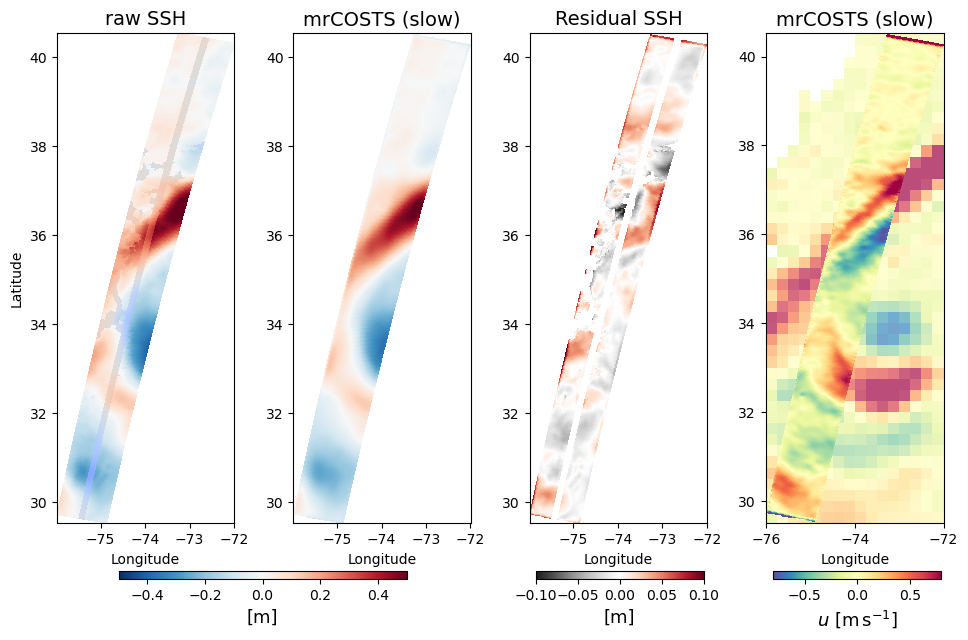

In [25]:
tt = ds.cycle_num[-20]

fig, (ax1,ax2,ax3,ax4) = plt.subplots(figsize=(12,7), nrows=1, ncols=4)

ax1.pcolor(dsGS.longitude-360.,
           dsGS.latitude,
           (SSHa_interp
            - h_interp.mean(['num_pixels','num_lines'])).sel(cycle_num=tt), 
           cmap='coolwarm', vmax=.5, vmin=-.5,
           rasterized=True)
im0 = ax1.pcolor(dsGS.longitude-360.,
           dsGS.latitude,
           (SSHa_raw.where(mask_raw)
            - h_interp.mean(['num_pixels','num_lines'])).sel(cycle_num=tt),
           cmap='RdBu_r', vmax=.5, vmin=-.5,
           rasterized=True)

ax2.pcolor(dsGS.longitude-360.,
           dsGS.latitude,
           low.sel(cycle_num=tt),
           cmap='RdBu_r', vmax=.5, vmin=-.5,
           rasterized=True)

im1 = ax3.pcolor(dsGS.longitude-360.,
           dsGS.latitude,
           ((SSHa_raw
             - h_interp.mean(['num_pixels','num_lines'])
            ).sel(cycle_num=tt)
            - low.sel(cycle_num=tt).data
           ),
           cmap='RdGy_r', vmax=.1, vmin=-.1,
           rasterized=True)

ax4.pcolormesh(daviso.longitude.isel(longitude=slice(2,-2)), 
               daviso.latitude.isel(latitude=slice(2,-2)),
               daviso.ugos.isel(time=0, latitude=slice(2,-2),
                                longitude=slice(2,-2)),
               cmap='Spectral_r', vmax=.8, vmin=-.8,
               rasterized=True,
               alpha=.7
              )
im2 = ax4.pcolor(.5*(dsGS.longitude[:-1]+dsGS.longitude[1:])-360.,
           .5*(dsGS.latitude[:-1]+dsGS.latitude[1:]),
           dvs.u.sel(cycle_num=tt),
           cmap='Spectral_r', vmax=.8, vmin=-.8,
           rasterized=True
                )

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

ax1.set_ylabel(r"Latitude")
ax1.set_xlabel(r"Longitude")
ax2.set_xlabel(r"Longitude")
ax3.set_xlabel(r"Longitude")
ax4.set_xlabel(r"Longitude")

ax1.set_title(r"raw SSH", fontsize=14)
ax2.set_title(r"mrCOSTS (slow)", fontsize=14)
ax3.set_title(r"Residual SSH", fontsize=14)
ax4.set_title(r"mrCOSTS (slow)", fontsize=14)

fig.subplots_adjust(bottom=.18, hspace=.2, wspace=.07) 
cbax0 = fig.add_axes([0.1945, 0.1, 0.24, 0.012])
cbar0 = fig.colorbar(im0, cax=cbax0, orientation='horizontal')
cbar0.set_label(r"[m]", fontsize=13)

cbax1 = fig.add_axes([0.542, 0.1, 0.14, 0.012])
cbar1 = fig.colorbar(im1, cax=cbax1, orientation='horizontal')
cbar1.set_label(r"[m]", fontsize=13)

cbax2 = fig.add_axes([0.74, 0.1, 0.14, 0.012])
cbar2 = fig.colorbar(im2, cax=cbax2, orientation='horizontal')
cbar2.set_label(r"$u$ [m$\,$s$^{-1}$]", fontsize=13)

plt.savefig(op.join(sdir,'Figs/SWOT_mrCOSTS_SSHrecon.pdf'))

In [26]:
fiso = gsw.f(daviso.latitude.isel(latitude=slice(1,-1)))
lonviso, latviso = np.meshgrid(daviso.longitude, daviso.latitude)

dxiso = gsw.distance(lonviso, latviso, p=0, axis=-1)
dyiso = gsw.distance(lonviso, latviso, p=0, axis=0)

u_xiso = ( np.diff(daviso.ugos,axis=-1) / dxiso )
v_yiso = ( np.diff(daviso.vgos,axis=-2) / dyiso )
u_xiso = .5*(u_xiso[...,1:-1,1:] + u_xiso[...,1:-1,:-1])
v_yiso = .5*(v_yiso[...,:-1,1:-1] + v_yiso[...,1:,1:-1])

u_yiso = ( np.diff(daviso.ugos,axis=-2) / dyiso )
v_xiso = ( np.diff(daviso.vgos,axis=-1) / dxiso )
u_yiso = .5*(u_yiso[...,:-1,1:-1] + u_yiso[...,1:,1:-1])
v_xiso = .5*(v_xiso[...,1:-1,1:] + v_xiso[...,1:-1,:-1])
        
vortiso = v_xiso - u_yiso

sniso = u_xiso - v_yiso
ssiso = v_xiso + u_yiso
strainiso = np.sqrt(sniso**2 + ssiso**2)

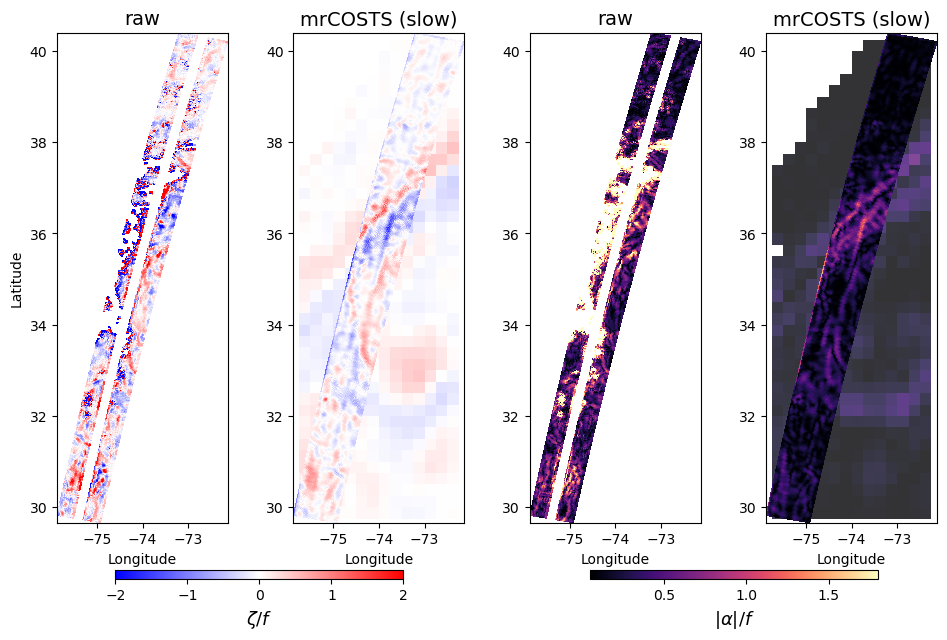

In [27]:
nnp = 4
nnl = 3
dn = 4

fig, (ax2,ax3,ax4,ax5) = plt.subplots(figsize=(12,7), nrows=1, ncols=4)

im0 = ax2.pcolor(dsGS.longitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                                     num_pixels=slice(nnp,-nnp)
                                    )-360.,
           dsGS.latitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                              num_pixels=slice(nnp,-nnp)),
           (vort_raw.sel(cycle_num=tt)
            / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                       num_pixels=slice(1,-1))).data
           ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                  XF=slice(nnp-1,-nnp+1)),
           cmap='bwr', vmax=2., vmin=-2.,
           rasterized=True)

ax3.pcolormesh(daviso.longitude.isel(longitude=slice(3,-3)), 
               daviso.latitude.isel(latitude=slice(3,-3)),
               (vortiso[0]/fiso.data[:,np.newaxis])[2:-2,2:-2],
               cmap='bwr', vmax=2., vmin=-2.,
               alpha=.8,
               rasterized=True
              )

ax3.pcolor(dsGS.longitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                               num_pixels=slice(nnp,-nnp)
                              )-360.,
           dsGS.latitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                              num_pixels=slice(nnp,-nnp)),
    # low.XC[1:-1], low.YC[1:-1],
           (vort_interp.sel(cycle_num=tt)
            # / gsw.f(dvs.YF)
            / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                       num_pixels=slice(1,-1))).data
           ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                  XF=slice(nnp-1,-nnp+1)),
           cmap='bwr', vmax=2., vmin=-2.,
           rasterized=True)

im1 = ax4.pcolor(dsGS.longitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                                     num_pixels=slice(nnp,-nnp)
                                    )-360.,
           dsGS.latitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                              num_pixels=slice(nnp,-nnp)),
           (strain_raw.sel(cycle_num=tt) 
            / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                       num_pixels=slice(1,-1))).data
           ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                  XF=slice(nnp-1,-nnp+1)),
           cmap='magma', vmax=1.8, vmin=.05,
           rasterized=True)

ax5.pcolormesh(daviso.longitude.isel(longitude=slice(3,-3)), 
               daviso.latitude.isel(latitude=slice(3,-3)),
               (strainiso[0]/fiso.data[:,np.newaxis])[2:-2,2:-2],
               cmap='magma', vmax=1.8, vmin=.05,
               alpha=.8,
               rasterized=True
              )

ax5.pcolor(dsGS.longitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                               num_pixels=slice(nnp,-nnp)
                              )-360.,
           dsGS.latitude.isel(num_lines=slice(nnl+dn,-nnl-dn), 
                              num_pixels=slice(nnp,-nnp)),
    # low.XC[1:-1], low.YC[1:-1],
           (strain_interp.sel(cycle_num=tt)
            # / gsw.f(dvs.YF)
            / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                       num_pixels=slice(1,-1))).data
           ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                  XF=slice(nnp-1,-nnp+1)),
           cmap='magma', vmax=1.8, vmin=.05,
           rasterized=True)

ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')
ax5.set_aspect('equal')

ax2.set_ylabel(r"Latitude")
ax2.set_xlabel(r"Longitude")
ax3.set_xlabel(r"Longitude")
ax4.set_xlabel(r"Longitude")
ax5.set_xlabel(r"Longitude")

ax2.set_title(r"raw", fontsize=14)
ax3.set_title(r"mrCOSTS (slow)", fontsize=14)
ax4.set_title(r"raw", fontsize=14)
ax5.set_title(r"mrCOSTS (slow)", fontsize=14)

fig.subplots_adjust(bottom=.18, hspace=.2, wspace=.07) 
cbax0 = fig.add_axes([0.1945, 0.1, 0.24, 0.012])
cbar0 = fig.colorbar(im0, cax=cbax0, orientation='horizontal')
cbar0.set_label(r"$\zeta/f$", fontsize=13)

cbax1 = fig.add_axes([0.59, 0.1, 0.24, 0.012])
cbar1 = fig.colorbar(im1, cax=cbax1, orientation='horizontal')
cbar1.set_label(r"$|\alpha|/f$", fontsize=13)

plt.savefig(op.join(sdir,'Figs/SWOT_mrCOSTS_vort-strain.pdf'))

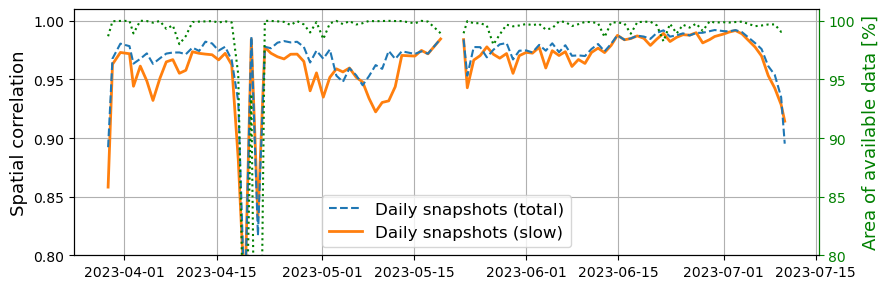

In [55]:
rslwDMD = xr.corr(SSHa_raw.where(mask_raw), low.where(mask_raw), 
                  dim=['num_pixels','num_lines'])
rtotDMD = xr.corr(SSHa_raw.where(mask_raw), tot.where(mask_raw), 
                  dim=['num_pixels','num_lines'])
# rcoDMD12_d = xr.corr(SSH_d, xr.DataArray(mrSSH12_d, dims=SSH_d.dims), 
#                    dim=['lat','lon'])

fig, ax = plt.subplots(figsize=(9,3))
ax2 = ax.twinx()
fig.set_tight_layout(True)

# ax.fill_between(np.array([0, 4]), 
#                 .86, 1.01, color='k', alpha=.15)
# ax.fill_between(np.array([len(SSHa_raw.cycle_num)-5, 
#                           len(SSHa_raw.cycle_num)-1]), 
#                 .86, 1.01, color='k', alpha=.15)
ax.plot(ds.time.mean(['pass_num','num_lines']
                    ).sel(cycle_num=SSHa_raw.cycle_num), rtotDMD, ls='--', 
        label=r"Daily snapshots (total)", zorder=10)
ax.plot(ds.time.mean(['pass_num','num_lines']
                    ).sel(cycle_num=SSHa_raw.cycle_num), rslwDMD, lw=2,
        label=r"Daily snapshots (slow)", zorder=4)
# ax.plot(np.arange(.5,len(SSH_d)+.5), rcoDMD12_d, ls=':', 
#         label=r"Daily ave. (12 hourly; slow)")
ax2.plot(ds.time.mean(['pass_num','num_lines']
                     ).sel(cycle_num=R.cycle_num), 
         R*1e2, 'g:')

ax.legend(loc='lower center', fontsize=12)
ax.set_ylim([.8,1.01])
ax2.set_ylim([80,101])
ax.set_ylabel(r"Spatial correlation", fontsize=13)
ax2.set_ylabel(r"Area of available data [$\%$]", fontsize=13, c='g')
ax2.spines['right'].set_color('green')
ax2.tick_params(axis='y', colors='green')
# ax.set_xlabel(r"[Days]", fontsize=13)
ax.grid(True)
plt.savefig(op.join(sdir,'Figs/SWOT_mrCOSTS_correlation.pdf'))

In [49]:
daviso4 = xr.open_mfdataset(op.join(avidir,
                             '04-2023/dataset-uv-nrt-daily_*.nc')
                    ).sel(latitude=slice(30-1.,40+1.), longitude=slice(284-360-.5,288-360+.5)
                         ).chunk({'time':1})
daviso5 = xr.open_mfdataset(op.join(avidir,
                             '05-2023/dataset-uv-nrt-daily_*.nc')
                    ).sel(latitude=slice(30-1.,40+1.), longitude=slice(284-360-.5,288-360+.5)
                         ).chunk({'time':1})
daviso6 = xr.open_mfdataset(op.join(avidir,
                             '06-2023/dataset-uv-nrt-daily_*.nc')
                    ).sel(latitude=slice(30-1.,40+1.), longitude=slice(284-360-.5,288-360+.5)
                         ).chunk({'time':1})
davisoAMJ = xr.concat([xr.concat([daviso4,daviso5],'time'),
                       daviso6],'time')
davisoAMJ

<xarray.Dataset>
Dimensions:    (time: 91, latitude: 48, longitude: 20, depth: 2)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01T12:00:00 ... 2023-06-30T12:00:00
  * latitude   (latitude) float32 29.12 29.38 29.62 29.88 ... 40.38 40.62 40.88
  * longitude  (longitude) float32 -76.38 -76.12 -75.88 ... -72.12 -71.88 -71.62
  * depth      (depth) int16 0 15
Data variables: (12/13)
    crs        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    ue         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    ve         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    ugos       (time, latitude, longitude) float32 dask.array<chunksize=(1, 48, 20), meta=np.ndarray>
    ...         ...
    err_uo     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    err_vo     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    err_ue     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    err_ve     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    err_ugos   (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
    err_vgos   (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 2, 48, 20), meta=np.ndarray>
Attributes: (12/17)
    geospatial_lon_units:     degrees_east
    geospatial_vertical_max:  0.0
    product_version:          3.0
    geospatial_lat_units:     degrees_north
    creation_date:            2023-07-26 12:11:51
    contact:                  servicedesk.cmems@mercator-ocean.eu
    ...                       ...
    lon_max:                  179.875
    lon_res:                  0.25
    lat_min:                  -89.875
    lat_max:                  89.875
    lat_res:                  0.25
    title:                    Daily mean total surface and 15m velocities

In [50]:
u_xisoAMJ = ( np.diff(davisoAMJ.ugos,axis=-1) / dxiso )
v_yisoAMJ = ( np.diff(davisoAMJ.vgos,axis=-2) / dyiso )
u_xisoAMJ = .5*(u_xisoAMJ[...,1:-1,1:] + u_xisoAMJ[...,1:-1,:-1])
v_yisoAMJ = .5*(v_yisoAMJ[...,:-1,1:-1] + v_yisoAMJ[...,1:,1:-1])

u_yisoAMJ = ( np.diff(davisoAMJ.ugos,axis=-2) / dyiso )
v_xisoAMJ = ( np.diff(davisoAMJ.vgos,axis=-1) / dxiso )
u_yisoAMJ = .5*(u_yisoAMJ[...,:-1,1:-1] + u_yisoAMJ[...,1:,1:-1])
v_xisoAMJ = .5*(v_xisoAMJ[...,1:-1,1:] + v_xisoAMJ[...,1:-1,:-1])
        
vortisoAMJ = xr.DataArray(v_xisoAMJ - u_yisoAMJ,
                          dims=['time','latitude','longitude'],
                          coords={'time':davisoAMJ.time,
                                  'latitude':davisoAMJ.latitude[1:-1].data,
                                  'longitude':davisoAMJ.longitude[1:-1].data}
                         ).chunk({'time':1})

snisoAMJ = u_xisoAMJ - v_yisoAMJ
ssisoAMJ = v_xisoAMJ + u_yisoAMJ
strisoAMJ = xr.DataArray(np.sqrt(snisoAMJ**2 + ssisoAMJ**2),
                         dims=['time','latitude','longitude'],
                         coords={'time':davisoAMJ.time,
                                 'latitude':davisoAMJ.latitude[1:-1].data,
                                 'longitude':davisoAMJ.longitude[1:-1].data}
                        ).chunk({'time':1})
strisoAMJ

<xarray.DataArray (time: 91, latitude: 46, longitude: 18)>
dask.array<xarray-<this-array>, shape=(91, 46, 18), dtype=float64, chunksize=(1, 46, 18), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01T12:00:00 ... 2023-06-30T12:00:00
  * latitude   (latitude) float32 29.38 29.62 29.88 30.12 ... 40.12 40.38 40.62
  * longitude  (longitude) float32 -76.12 -75.88 -75.62 ... -72.38 -72.12 -71.88

In [51]:
vbins = np.linspace(-4e0,4e0,60)
sbins = np.linspace(0,4e0,30)
hist_r = xhist((strain_raw
                / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                           num_pixels=slice(1,-1))).data
               ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                      XF=slice(nnp-1,-nnp+1)
                     ).rename('strain'
                             ).chunk({'cycle_num':10,'YF':-1,'XF':-1}), 
               (vort_raw
                / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                           num_pixels=slice(1,-1))).data
               ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                      XF=slice(nnp-1,-nnp+1)
                     ).rename('vort'
                             ).chunk({'cycle_num':10,'YF':-1,'XF':-1}), 
               bins=[sbins, vbins], density=True
              ).compute()
hist_c = xhist((strain_interp
                # / gsw.f(dvs.YF)
                / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                           num_pixels=slice(1,-1))).data
               ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                      XF=slice(nnp-1,-nnp+1)
                     ).rename('strain'
                             ).chunk({'cycle_num':10,'YF':-1,'XF':-1}), 
               (vort_interp
                # / gsw.f(dvs.YF)
                / gsw.f(dsGS.latitude.isel(num_lines=slice(1,-1), 
                                           num_pixels=slice(1,-1))).data
               ).isel(YF=slice(nnl+(dn-1),-nnl-(dn-1)),
                      XF=slice(nnp-1,-nnp+1)
                     ).rename('vort'
                             ).chunk({'cycle_num':10,'YF':-1,'XF':-1}), 
               bins=[sbins, vbins], density=True
              ).compute()
hist_viso = xhist((strisoAMJ
                # / gsw.f(dvs.YF)
                / fiso
               ).isel(latitude=slice(1,-1),longitude=slice(1,-1)
                     ).rename('strain'
                             ), 
               (vortisoAMJ
                # / gsw.f(dvs.YF)
                / fiso
               ).isel(latitude=slice(1,-1),longitude=slice(1,-1)
                     ).rename('vort'
                             ), 
               bins=[sbins, vbins], density=True
              ).compute()

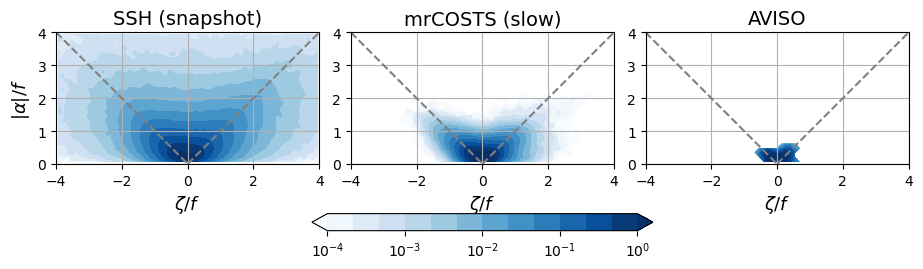

In [74]:
fig, axes = plt.subplots(figsize=(11,4.3), nrows=1, ncols=3)
# fig.set_tight_layout(True)

im0 = axes[0].contourf(hist_r.vort_bin,
                 hist_r.strain_bin,
                 hist_r, 
                 cmap='Blues', locator=ticker.LogLocator(), 
                 norm=clr.LogNorm(), levels=np.logspace(-4,0,13),
                 extend='both'
#                       rasterized=True
               )
im1 = axes[1].contourf(hist_c.vort_bin,
                 hist_c.strain_bin,
                 hist_c, 
                 cmap='Blues', locator=ticker.LogLocator(), 
                 norm=clr.LogNorm(), levels=np.logspace(-4,0,13),
                 extend='both'
#                       rasterized=True
               )
im2 = axes[2].contourf(hist_viso.vort_bin,
                 hist_viso.strain_bin,
                 hist_viso, 
                 cmap='Blues', locator=ticker.LogLocator(), 
                 norm=clr.LogNorm(), levels=np.logspace(-4,0,13),
                 extend='both'
#                       rasterized=True
               )

for c in im0.collections:
    c.set_rasterized(True)
for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)

axes[0].plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
axes[0].plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
axes[1].plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
axes[1].plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
axes[2].plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
axes[2].plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')

axes[0].set_xlim([-4,4])
axes[0].set_ylim([0,4])
axes[1].set_xlim([-4,4])
axes[1].set_ylim([0,4])
axes[2].set_xlim([-4,4])
axes[2].set_ylim([0,4])

axes[0].set_title(r"SSH (snapshot)", fontsize=14)
axes[1].set_title(r"mrCOSTS (slow)", fontsize=14)
axes[2].set_title(r"AVISO", fontsize=14)

axes[0].set_xlabel(r"$\zeta/f$", fontsize=13)
axes[0].set_ylabel(r"$|\alpha|/f$", fontsize=13)
axes[1].set_xlabel(r"$\zeta/f$", fontsize=13)
axes[2].set_xlabel(r"$\zeta/f$", fontsize=13)

axes[0].grid(True)
axes[0].set_aspect('equal')
axes[1].grid(True)
axes[1].set_aspect('equal')
axes[2].grid(True)
axes[2].set_aspect('equal')

fig.subplots_adjust(hspace=.06, wspace=.12)
cbar = fig.colorbar(im0, orientation='horizontal', ax=axes, shrink=.4, 
                    ticks=[1e-4,1e-3,1e-2,1e-1,1e0])

plt.savefig(op.join(sdir,'Figs/vort-strain-SWOTjointPDF.pdf'))